In [1]:
import os
import gc
from pathlib import Path
from functools import lru_cache

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from tqdm.auto import tqdm

import mne

plt.style.use("seaborn-v0_8")
sns.set_context("notebook", font_scale=1.1)
pio.renderers.default = "notebook_connected"
mne.set_log_level("WARNING")
pd.options.display.float_format = lambda x: f"{x:0.3f}"

In [2]:
from pathlib import Path

# Base dataset path on Kaggle
DATA_ROOT = Path("/kaggle/input/eeg-motorimagery-eegmmidb-v1-0-0/physionet.org/files/eegmmidb/1.0.0")

# Create derived data directory under working directory (writable)
DERIVED_DIR = Path("/kaggle/working/derived")
DERIVED_DIR.mkdir(parents=True, exist_ok=True)

# Cache files
RUN_SUMMARY_CACHE = DERIVED_DIR / "run_summary.pkl"
ERROR_LOG_CACHE = DERIVED_DIR / "run_summary_errors.json"

# Verify dataset presence
assert DATA_ROOT.exists(), f"Expected PhysioNet files under {DATA_ROOT.as_posix()}"

# Collect subject directories
SUBJECT_IDS = sorted(p.name for p in DATA_ROOT.iterdir() if p.is_dir())
print(f"Detected {len(SUBJECT_IDS)} subjects")
SUBJECT_IDS[:10]


Detected 109 subjects


['S001',
 'S002',
 'S003',
 'S004',
 'S005',
 'S006',
 'S007',
 'S008',
 'S009',
 'S010']

In [3]:
RUN_METADATA = {
    'R01': {'session': 'baseline', 'category': 'resting_state', 'task': 'Baseline eyes open'},
    'R02': {'session': 'baseline', 'category': 'resting_state', 'task': 'Baseline eyes closed'},
    'R03': {'session': 'run_1', 'category': 'motor_execution', 'task': 'Open/close left fist (executed)'},
    'R04': {'session': 'run_1', 'category': 'motor_execution', 'task': 'Open/close right fist (executed)'},
    'R05': {'session': 'run_1', 'category': 'motor_execution', 'task': 'Open/close both fists (executed)'},
    'R06': {'session': 'run_1', 'category': 'motor_execution', 'task': 'Open/close both feet (executed)'},
    'R07': {'session': 'run_2', 'category': 'motor_imagery', 'task': 'Imagine left fist'},
    'R08': {'session': 'run_2', 'category': 'motor_imagery', 'task': 'Imagine right fist'},
    'R09': {'session': 'run_2', 'category': 'motor_imagery', 'task': 'Imagine both fists'},
    'R10': {'session': 'run_2', 'category': 'motor_imagery', 'task': 'Imagine both feet'},
    'R11': {'session': 'run_3', 'category': 'motor_execution', 'task': 'Alternate fists and feet (executed)'},
    'R12': {'session': 'run_3', 'category': 'motor_execution', 'task': 'Alternate fists and feet (executed, repeat)'},
    'R13': {'session': 'run_3', 'category': 'motor_imagery', 'task': 'Alternate fists and feet (imagery)'},
    'R14': {'session': 'run_3', 'category': 'motor_imagery', 'task': 'Alternate fists and feet (imagery, repeat)'},
}

RUN_METADATA

{'R01': {'session': 'baseline',
  'category': 'resting_state',
  'task': 'Baseline eyes open'},
 'R02': {'session': 'baseline',
  'category': 'resting_state',
  'task': 'Baseline eyes closed'},
 'R03': {'session': 'run_1',
  'category': 'motor_execution',
  'task': 'Open/close left fist (executed)'},
 'R04': {'session': 'run_1',
  'category': 'motor_execution',
  'task': 'Open/close right fist (executed)'},
 'R05': {'session': 'run_1',
  'category': 'motor_execution',
  'task': 'Open/close both fists (executed)'},
 'R06': {'session': 'run_1',
  'category': 'motor_execution',
  'task': 'Open/close both feet (executed)'},
 'R07': {'session': 'run_2',
  'category': 'motor_imagery',
  'task': 'Imagine left fist'},
 'R08': {'session': 'run_2',
  'category': 'motor_imagery',
  'task': 'Imagine right fist'},
 'R09': {'session': 'run_2',
  'category': 'motor_imagery',
  'task': 'Imagine both fists'},
 'R10': {'session': 'run_2',
  'category': 'motor_imagery',
  'task': 'Imagine both feet'},
 '

In [4]:
from collections import defaultdict

inventory_records = []
missing_records = []
for subject in SUBJECT_IDS:
    subject_dir = DATA_ROOT / subject
    subject_runs = sorted(subject_dir.glob('*.edf'))
    available = {path.stem[-3:]: path for path in subject_runs}
    for run_id in [f'R{idx:02d}' for idx in range(1, 15)]:
        record = {
            'subject': subject,
            'run': run_id,
            'available': run_id in available,
            'file': available.get(run_id)
        }
        if run_id in RUN_METADATA:
            record.update(RUN_METADATA[run_id])
        inventory_records.append(record)
        if run_id not in available:
            missing_records.append({'subject': subject, 'run': run_id})

inventory_df = pd.DataFrame(inventory_records)
missing_df = pd.DataFrame(missing_records)

print(f"Missing runs: {len(missing_df)} (out of {len(SUBJECT_IDS) * 14})")
inventory_df.head()

Missing runs: 0 (out of 1526)


,subject,run,available,file,session,category,task
0,S001,R01,True,/kaggle/input/eeg-motorimagery-eegmmidb-v1-0-0...,baseline,resting_state,Baseline eyes open
1,S001,R02,True,/kaggle/input/eeg-motorimagery-eegmmidb-v1-0-0...,baseline,resting_state,Baseline eyes closed
2,S001,R03,True,/kaggle/input/eeg-motorimagery-eegmmidb-v1-0-0...,run_1,motor_execution,Open/close left fist (executed)
3,S001,R04,True,/kaggle/input/eeg-motorimagery-eegmmidb-v1-0-0...,run_1,motor_execution,Open/close right fist (executed)
4,S001,R05,True,/kaggle/input/eeg-motorimagery-eegmmidb-v1-0-0...,run_1,motor_execution,Open/close both fists (executed)


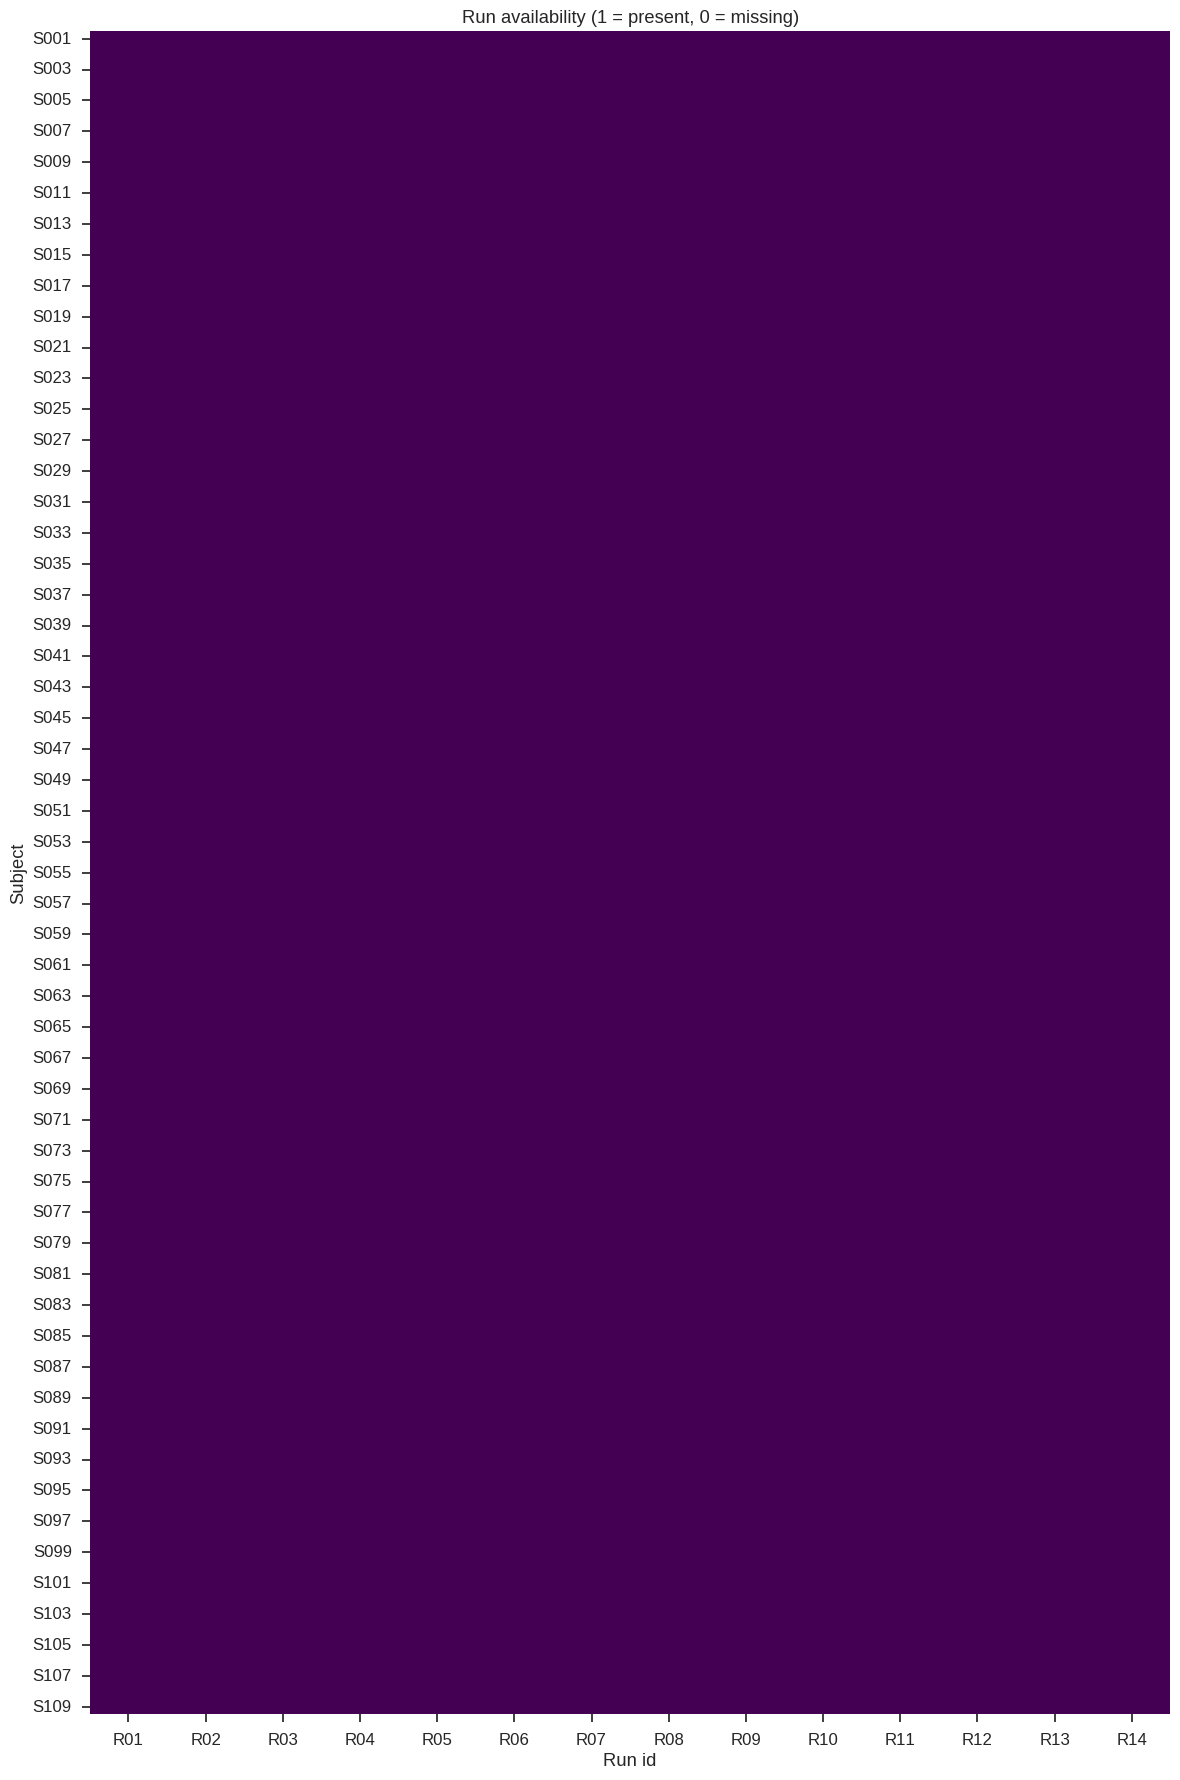

In [5]:
run_matrix = (inventory_df.assign(present=lambda df: df['available'].astype(int))
                               .pivot(index='subject', columns='run', values='present')
                               .fillna(0))
plt.figure(figsize=(12, min(0.25 * len(run_matrix), 18)))
sns.heatmap(run_matrix, cmap='viridis', cbar=False)
plt.title('Run availability (1 = present, 0 = missing)')
plt.xlabel('Run id')
plt.ylabel('Subject')
plt.tight_layout()
plt.show()

In [6]:
import warnings
from typing import Dict, Any

EEG_DECIM_FOR_STATS = 10
EEG_DECIM_FOR_PSD = 2
FLAT_STD_THRESHOLD_UV = 0.5
NOISY_STD_THRESHOLD_UV = 120.0
CLIP_THRESHOLD_UV = 200.0
BAND_DEFS = {
    'delta': (1.0, 4.0),
    'theta': (4.0, 8.0),
    'alpha': (8.0, 13.0),
    'beta': (13.0, 30.0),
    'gamma': (30.0, 45.0),
}

@lru_cache(maxsize=256)
def _load_raw_cache(edf_path: str) -> mne.io.BaseRaw:
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose='ERROR')
    cleaned_names = {name: name.rstrip('.') for name in raw.ch_names}
    raw.rename_channels(cleaned_names)
    eeg_picks = mne.pick_types(raw.info, eeg=True)
    raw.pick(eeg_picks)
    raw.set_montage('standard_1020', on_missing='ignore', match_case=False)
    return raw


def summarize_run(edf_path: Path) -> Dict[str, Any]:
    edf_path = Path(edf_path)
    run_id = edf_path.stem[-3:]
    subject_id = edf_path.parent.name
    meta = RUN_METADATA.get(run_id, {})

    raw = _load_raw_cache(str(edf_path))
    raw_copy = raw.copy()

    sfreq = float(raw_copy.info['sfreq'])
    duration = float(raw_copy.times[-1])
    eeg_names = raw_copy.ch_names

    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        data_full = raw_copy.get_data()
    data_uv = data_full[:, ::EEG_DECIM_FOR_STATS] * 1e6

    channel_std = data_uv.std(axis=1)
    channel_ptp = data_uv.ptp(axis=1)

    flat_channels = [name for name, std in zip(eeg_names, channel_std) if std < FLAT_STD_THRESHOLD_UV]
    noisy_channels = [name for name, std in zip(eeg_names, channel_std) if std > NOISY_STD_THRESHOLD_UV]
    clip_fraction = float((np.abs(data_uv) > CLIP_THRESHOLD_UV).mean())

    events, event_id = mne.events_from_annotations(raw_copy, verbose='ERROR')
    event_counts = {label: int((events[:, 2] == code).sum()) for label, code in event_id.items()}

    psd_raw = raw_copy.copy()
    target_sfreq = max(sfreq / EEG_DECIM_FOR_PSD, 80.0)
    if abs(target_sfreq - sfreq) > 1e-6:
        psd_raw.resample(target_sfreq, npad='auto')

    nyquist = target_sfreq / 2.0
    fmax_psd = min(60.0, nyquist - 1.0)
    psd = psd_raw.compute_psd(method='welch', fmin=1.0, fmax=fmax_psd, n_fft=512,
                              n_overlap=256, verbose='ERROR')
    psd_data = psd.get_data()
    freqs = psd.freqs
    total_band_mask = (freqs >= 1.0) & (freqs <= 45.0)
    total_power = psd_data[:, total_band_mask].sum(axis=1)
    total_power[total_power == 0] = np.nan

    band_features = {}
    for band, (fmin, fmax) in BAND_DEFS.items():
        mask = (freqs >= fmin) & (freqs < fmax)
        band_power = psd_data[:, mask].sum(axis=1)
        band_ratio = band_power / total_power
        band_features[f'band_{band}_rel_power_mean'] = float(np.nanmean(band_ratio))
        band_features[f'band_{band}_rel_power_std'] = float(np.nanstd(band_ratio))

    line_mask = (freqs >= 58.0) & (freqs <= 62.0)
    beta_mask = (freqs >= 13.0) & (freqs <= 30.0)
    line_power = float(np.nanmean(psd_data[:, line_mask])) if np.any(line_mask) else np.nan
    beta_power = float(np.nanmean(psd_data[:, beta_mask])) if np.any(beta_mask) else np.nan
    if np.isnan(beta_power) or beta_power <= 0:
        line_noise_ratio = np.nan
    else:
        line_noise_ratio = float(line_power / beta_power)

    summary = {
        'subject': subject_id,
        'run': run_id,
        'session': meta.get('session', 'unknown'),
        'category': meta.get('category', 'unknown'),
        'task': meta.get('task', 'unknown'),
        'sfreq': sfreq,
        'n_channels': len(eeg_names),
        'duration_s': duration,
        'mean_channel_std_uv': float(np.mean(channel_std)),
        'median_channel_std_uv': float(np.median(channel_std)),
        'p90_channel_std_uv': float(np.percentile(channel_std, 90)),
        'max_channel_std_uv': float(np.max(channel_std)),
        'p95_channel_ptp_uv': float(np.percentile(channel_ptp, 95)),
        'max_channel_ptp_uv': float(np.max(channel_ptp)),
        'clip_fraction_over_200uv': clip_fraction,
        'max_abs_signal_uv': float(np.max(np.abs(data_uv))),
        'flat_channel_count': len(flat_channels),
        'noisy_channel_count': len(noisy_channels),
        'flat_channels': flat_channels,
        'noisy_channels': noisy_channels,
        'events_total': int(events.shape[0]),
        'events_rest': event_counts.get('T0', 0),
        'events_label_1': event_counts.get('T1', 0),
        'events_label_2': event_counts.get('T2', 0),
        'line_noise_ratio': line_noise_ratio,
        'cache_key': str(edf_path.relative_to(DATA_ROOT.parent)),
    }
    summary.update(band_features)
    return summary

In [7]:
def build_run_summary(subject_subset=None, force_recompute=False):
    subject_list = SUBJECT_IDS if subject_subset is None else list(subject_subset)
    if RUN_SUMMARY_CACHE.exists() and not force_recompute:
        run_df = pd.read_pickle(RUN_SUMMARY_CACHE)
        error_df = pd.read_json(ERROR_LOG_CACHE) if ERROR_LOG_CACHE.exists() else pd.DataFrame()
        if 'subject' in run_df.columns:
            existing_subjects = set(run_df['subject'].unique())
        else:
            existing_subjects = set()
        if run_df.empty or not set(subject_list).issubset(existing_subjects):
            print('Cached summary incomplete or empty - recomputing from scratch')
        else:
            print('Loaded cached summaries from disk')
            return run_df[run_df['subject'].isin(subject_list)].reset_index(drop=True), error_df

    records = []
    errors = []
    for subject in tqdm(subject_list, desc='Summarising runs'):
        subject_dir = DATA_ROOT / subject
        for edf_path in sorted(subject_dir.glob('*.edf')):
            try:
                records.append(summarize_run(edf_path))
            except Exception as exc:
                errors.append({
                    'subject': subject,
                    'run': edf_path.stem[-3:],
                    'file': str(edf_path),
                    'error': repr(exc)
                })
    run_df = pd.DataFrame(records)
    error_df = pd.DataFrame(errors)
    if subject_subset is None:
        run_df.to_pickle(RUN_SUMMARY_CACHE)
        error_df.to_json(ERROR_LOG_CACHE, orient='records', indent=2)
        print(f'Persisted run summary cache to {RUN_SUMMARY_CACHE}')
    return run_df, error_df

In [8]:
SUBJECT_FILTER = None  # e.g. ['S001', 'S010'] for quick debugging
RUN_DF, ERROR_DF = build_run_summary(subject_subset=SUBJECT_FILTER, force_recompute=False)
if RUN_DF.empty:
    RUN_DF, ERROR_DF = build_run_summary(subject_subset=SUBJECT_FILTER, force_recompute=True)
RUN_DF.head()

Summarising runs:   0%|          | 0/109 [00:00<?, ?it/s]

Persisted run summary cache to /kaggle/working/derived/run_summary.pkl


,subject,run,session,category,task,sfreq,n_channels,duration_s,mean_channel_std_uv,median_channel_std_uv,...,band_delta_rel_power_mean,band_delta_rel_power_std,band_theta_rel_power_mean,band_theta_rel_power_std,band_alpha_rel_power_mean,band_alpha_rel_power_std,band_beta_rel_power_mean,band_beta_rel_power_std,band_gamma_rel_power_mean,band_gamma_rel_power_std
0,S001,R01,baseline,resting_state,Baseline eyes open,160.000,64,60.994,56.077,52.453,...,0.584,0.101,0.158,0.031,0.112,0.035,0.125,0.053,0.020,0.015
1,S001,R02,baseline,resting_state,Baseline eyes closed,160.000,64,60.994,52.818,50.629,...,0.330,0.105,0.133,0.037,0.388,0.135,0.130,0.039,0.019,0.017
2,S001,R03,run_1,motor_execution,Open/close left fist (executed),160.000,64,124.994,58.346,52.638,...,0.584,0.107,0.160,0.029,0.107,0.039,0.127,0.056,0.022,0.016
3,S001,R04,run_1,motor_execution,Open/close right fist (executed),160.000,64,124.994,52.817,52.675,...,0.551,0.079,0.170,0.029,0.113,0.032,0.140,0.051,0.027,0.018
4,S001,R05,run_1,motor_execution,Open/close both fists (executed),160.000,64,124.994,55.645,51.974,...,0.582,0.111,0.159,0.027,0.098,0.037,0.133,0.061,0.028,0.020


In [9]:
if RUN_SUMMARY_CACHE.exists():
    RUN_SUMMARY_CACHE.unlink()
    print(f'Deleted cached summary: {RUN_SUMMARY_CACHE}')
if ERROR_LOG_CACHE.exists():
    ERROR_LOG_CACHE.unlink()
    print(f'Deleted error log: {ERROR_LOG_CACHE}')
print('Cache cleared. Will force recomputation.')

Deleted cached summary: /kaggle/working/derived/run_summary.pkl
Deleted error log: /kaggle/working/derived/run_summary_errors.json
Cache cleared. Will force recomputation.


In [10]:
print(f"Runs processed: {len(RUN_DF)}")
if not ERROR_DF.empty:
    display(ERROR_DF)
else:
    print('No read errors encountered')

Runs processed: 1526
No read errors encountered


In [11]:
trial_cols = ['events_rest', 'events_label_1', 'events_label_2']
trial_summary = (RUN_DF[['subject', 'run'] + trial_cols]
                 .set_index(['subject', 'run'])
                 .fillna(0)
                 .astype(int))
trial_summary.head()

events_rest  events_label_1  events_label_2
subject run                                             
S001    R01            1               0               0
        R02            1               0               0
        R03           15               8               7
        R04           15               8               7
        R05           15               8               7

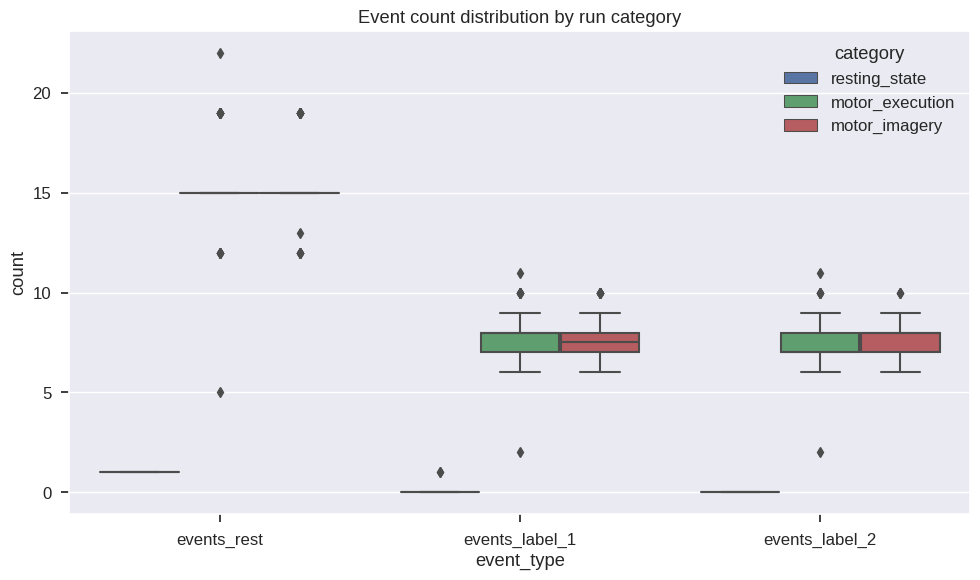

In [12]:
trial_long = RUN_DF.melt(id_vars=['subject', 'run', 'category'],
                         value_vars=trial_cols,
                         var_name='event_type', value_name='count')
plt.figure(figsize=(10, 6))
sns.boxplot(data=trial_long, x='event_type', y='count', hue='category')
plt.title('Event count distribution by run category')
plt.tight_layout()
plt.show()

In [13]:
pivot_counts = (RUN_DF.pivot_table(index='subject', columns='run', values='events_total', aggfunc='sum')
                       .fillna(0))
fig = px.imshow(pivot_counts,
                labels=dict(color='Events'),
                color_continuous_scale='Plasma',
                title='Total events per subject/run')
fig.update_layout(height=max(400, 12 * len(pivot_counts)))
fig.show()

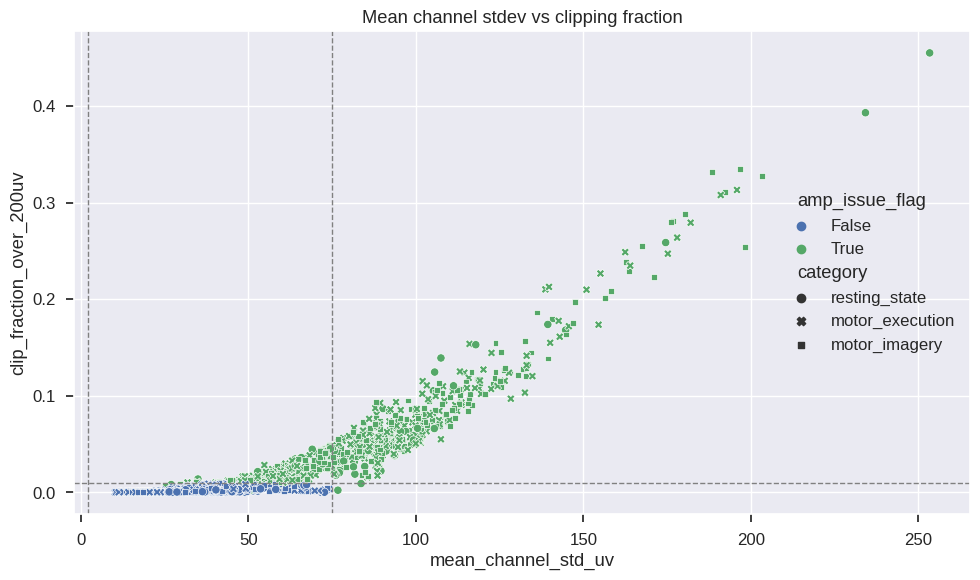

In [14]:
RUN_DF['has_flat_issue'] = RUN_DF['flat_channel_count'] > 0
RUN_DF['has_noisy_issue'] = RUN_DF['noisy_channel_count'] > 0
RUN_DF['amp_issue_flag'] = (
    RUN_DF['has_flat_issue'] |
    RUN_DF['has_noisy_issue'] |
    (RUN_DF['mean_channel_std_uv'] < 2.0) |
    (RUN_DF['mean_channel_std_uv'] > 75.0) |
    (RUN_DF['clip_fraction_over_200uv'] > 0.01)
)

plt.figure(figsize=(10,6))
sns.scatterplot(data=RUN_DF,
                x='mean_channel_std_uv', y='clip_fraction_over_200uv',
                hue='amp_issue_flag', style='category')
plt.axvline(2.0, linestyle='--', color='grey', linewidth=1)
plt.axvline(75.0, linestyle='--', color='grey', linewidth=1)
plt.axhline(0.01, linestyle='--', color='grey', linewidth=1)
plt.title('Mean channel stdev vs clipping fraction')
plt.tight_layout()
plt.show()

In [15]:
fig = px.box(RUN_DF, x='category', y='mean_channel_std_uv', color='category', title='Channel variance by category')
fig.update_traces(notched=True)
fig.show()

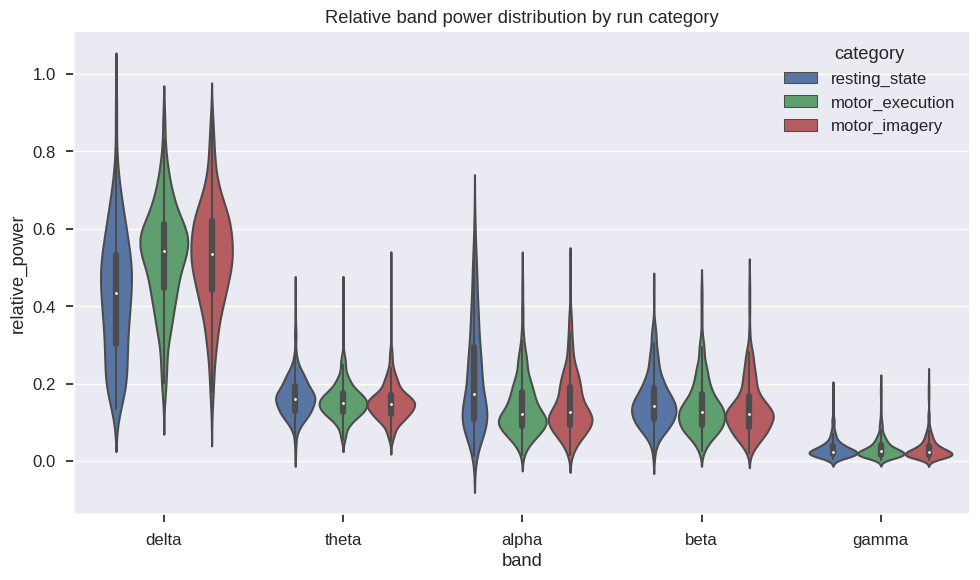

In [16]:
band_cols = [col for col in RUN_DF.columns if col.startswith('band_') and col.endswith('_mean')]
band_long = RUN_DF.melt(id_vars=['subject', 'run', 'category'],
                        value_vars=band_cols,
                        var_name='band', value_name='relative_power')
band_long['band'] = band_long['band'].str.replace('band_', '').str.replace('_rel_power_mean', '')
plt.figure(figsize=(10,6))
sns.violinplot(data=band_long, x='band', y='relative_power', hue='category', split=False)
plt.title('Relative band power distribution by run category')
plt.tight_layout()
plt.show()

In [17]:
fig = px.scatter(RUN_DF,
                 x='line_noise_ratio', y='band_alpha_rel_power_mean',
                 color='category', symbol='amp_issue_flag',
                 hover_data=['subject', 'run', 'task'],
                 title='Line noise vs alpha power balance')
fig.add_vline(x=2.0, line_dash='dash', line_color='red', annotation_text='line/noise threshold')
fig.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less



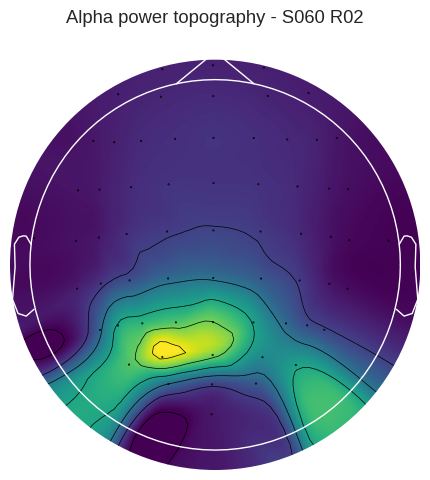

In [18]:
from mne.viz import plot_topomap

example_row = RUN_DF.sort_values('band_alpha_rel_power_mean', ascending=False).iloc[0]
example_path = DATA_ROOT / example_row['subject'] / f"{example_row['subject']}{example_row['run']}.edf"
example_raw = _load_raw_cache(str(example_path)).copy()

example_sfreq = example_raw.info['sfreq']
example_target_sfreq = max(example_sfreq / EEG_DECIM_FOR_PSD, 80.0)
if abs(example_target_sfreq - example_sfreq) > 1e-6:
    example_raw.resample(example_target_sfreq, npad='auto')

example_nyquist = example_target_sfreq / 2.0
example_fmax = min(60.0, example_nyquist - 1.0)

psd = example_raw.compute_psd(method='welch', fmin=1.0, fmax=example_fmax, n_fft=1024,
                             n_overlap=512, verbose='ERROR')
freqs = psd.freqs
data = psd.get_data()
alpha_mask = (freqs >= 8.0) & (freqs <= 13.0)
alpha_power = data[:, alpha_mask].mean(axis=1)
fig, ax = plt.subplots(figsize=(5,5))
plot_topomap(alpha_power, example_raw.info, axes=ax, show=False, cmap='viridis')
ax.set_title(f"Alpha power topography - {example_row['subject']} {example_row['run']}")
plt.tight_layout()
plt.show()

In [19]:
import numpy as np
from scipy.stats import zscore

numeric_cols = [
    "mean_channel_std_uv", "median_channel_std_uv", "p90_channel_std_uv",
    "max_channel_std_uv", "p95_channel_ptp_uv", "max_channel_ptp_uv",
    "clip_fraction_over_200uv", "max_abs_signal_uv", "band_alpha_rel_power_mean",
    "band_beta_rel_power_mean", "band_theta_rel_power_mean", "line_noise_ratio",
]

# keep only complete rows
z_df = RUN_DF[["subject", "run"] + numeric_cols].dropna()

# z-score entire numeric block at once
z_values = zscore(z_df[numeric_cols].to_numpy(dtype=float), axis=0, nan_policy="omit")
if isinstance(z_values, np.ma.MaskedArray):
    z_values = z_values.filled(np.nan)

z_scores = pd.DataFrame(z_values, columns=numeric_cols, index=z_df.index)

# compute max abs z and merge back
z_df = z_df.assign(max_abs_z=np.abs(z_scores).max(axis=1))
RUN_DF = RUN_DF.merge(z_df[["subject", "run", "max_abs_z"]], on=["subject", "run"], how="left")
RUN_DF["zscore_flag"] = RUN_DF["max_abs_z"] > 3.0

/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:2893: RuntimeWarning:

invalid value encountered in less_equal

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater



In [20]:
subject_summary = (
    RUN_DF.groupby('subject').agg({
        'run': 'nunique',
        'category': lambda s: ', '.join(sorted(set(s))),
        'duration_s': 'sum',
        'events_total': 'sum',
        'events_label_1': 'sum',
        'events_label_2': 'sum',
        'mean_channel_std_uv': ['median', 'min', 'max'],
        'clip_fraction_over_200uv': ['mean', 'max'],
        'line_noise_ratio': ['median', 'max'],
        'flat_channel_count': lambda s: int((s > 0).sum()),
        'noisy_channel_count': lambda s: int((s > 0).sum()),
        'amp_issue_flag': 'sum',
        'zscore_flag': 'sum'
    })
)
subject_summary.columns = ['_'.join(filter(None, col)).strip('_') for col in subject_summary.columns]
subject_summary = subject_summary.rename(columns={
    'run_nunique': 'runs_available',
    'category_<lambda>': 'categories_observed',
    'duration_s_sum': 'total_duration_s',
    'events_total_sum': 'total_events',
    'events_label_1_sum': 'total_label_1',
    'events_label_2_sum': 'total_label_2',
    'mean_channel_std_uv_median': 'median_mean_std_uv',
    'mean_channel_std_uv_min': 'min_mean_std_uv',
    'mean_channel_std_uv_max': 'max_mean_std_uv',
    'clip_fraction_over_200uv_mean': 'avg_clip_fraction',
    'clip_fraction_over_200uv_max': 'max_clip_fraction',
    'line_noise_ratio_median': 'median_line_noise_ratio',
    'line_noise_ratio_max': 'max_line_noise_ratio',
    'flat_channel_count_<lambda>': 'runs_with_flat_channels',
    'noisy_channel_count_<lambda>': 'runs_with_noisy_channels',
    'amp_issue_flag_sum': 'runs_with_amp_issue',
    'zscore_flag_sum': 'runs_with_zscore_outlier'
})
subject_summary['suspect_subject'] = (
    (subject_summary['runs_with_amp_issue'] > 0) |
    (subject_summary['runs_with_zscore_outlier'] > 0) |
    (subject_summary['max_clip_fraction'] > 0.05) |
    (subject_summary['median_line_noise_ratio'] > 2.5)
)
subject_summary.sort_values('runs_with_amp_issue', ascending=False).head()

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater



,runs_available,categories_observed,total_duration_s,total_events,total_label_1,total_label_2,median_mean_std_uv,min_mean_std_uv,max_mean_std_uv,avg_clip_fraction,max_clip_fraction,median_line_noise_ratio,max_line_noise_ratio,runs_with_flat_channels,runs_with_noisy_channels,runs_with_amp_issue,runs_with_zscore_outlier,suspect_subject
subject,,,,,,,,,,,,,,,,,,
S109,14,"motor_execution, motor_imagery, resting_state",1596.913,362,93,87,75.961,57.314,122.563,0.064,0.153,NaN,NaN,0,14,14,0,True
S096,14,"motor_execution, motor_imagery, resting_state",1621.913,362,90,90,92.090,72.135,132.505,0.091,0.156,NaN,NaN,0,14,14,0,True
S095,14,"motor_execution, motor_imagery, resting_state",1621.913,362,88,92,101.044,84.689,192.305,0.093,0.311,NaN,NaN,0,10,14,0,True
S032,14,"motor_execution, motor_imagery, resting_state",1621.913,362,88,92,101.113,81.769,132.793,0.063,0.124,NaN,NaN,0,13,14,0,True
S028,14,"motor_execution, motor_imagery, resting_state",1597.913,362,92,88,111.149,100.451,144.711,0.101,0.168,NaN,NaN,0,14,14,0,True


In [21]:
fig = px.scatter(subject_summary.reset_index(),
                 x='median_mean_std_uv', y='median_line_noise_ratio',
                 size='runs_with_amp_issue', color='suspect_subject',
                 hover_data=['subject', 'runs_available', 'avg_clip_fraction'],
                 title='Subject-level signal health overview')
fig.add_hline(y=2.5, line_dash='dash', line_color='red')
fig.add_vline(x=5.0, line_dash='dash', line_color='grey')
fig.show()

In [22]:
def plot_run_timeseries(subject_id: str, run_id: str, seconds: float = 8.0, channels=None):
    edf_path = DATA_ROOT / subject_id / f"{subject_id}{run_id}.edf"
    if not edf_path.exists():
        raise FileNotFoundError(edf_path)
    raw = _load_raw_cache(str(edf_path)).copy().load_data()
    if channels is None:
        channels = ['C3', 'Cz', 'C4', 'Pz']
    available = [ch for ch in channels if ch in raw.ch_names]
    data = raw.copy().pick_channels(available)
    sfreq = data.info['sfreq']
    stop = int(min(seconds * sfreq, data.n_times))
    array = data.get_data(stop=stop) * 1e6
    time = np.arange(stop) / sfreq
    df = pd.DataFrame({'time_s': np.tile(time, len(available)),
                       'channel': np.repeat(available, stop),
                       'amplitude_uV': array.reshape(len(available) * stop)})
    fig = px.line(df, x='time_s', y='amplitude_uV', color='channel',
                  title=f'{subject_id} {run_id} - first {seconds} s')
    fig.update_layout(xaxis_title='Time (s)', yaxis_title='Amplitude (uV)')
    fig.show()

plot_run_timeseries('S001', 'R03', seconds=6)

In [23]:
RUN_REPORT_PATH = DERIVED_DIR / 'physionet_run_summary.csv'
SUBJECT_REPORT_PATH = DERIVED_DIR / 'physionet_subject_summary.csv'

RUN_DF.sort_values(['subject', 'run']).to_csv(RUN_REPORT_PATH, index=False)
subject_summary.sort_values('suspect_subject', ascending=False).to_csv(SUBJECT_REPORT_PATH)
print(f'Exported run summary -> {RUN_REPORT_PATH}')
print(f'Exported subject summary -> {SUBJECT_REPORT_PATH}')

Exported run summary -> /kaggle/working/derived/physionet_run_summary.csv
Exported subject summary -> /kaggle/working/derived/physionet_subject_summary.csv


**DATA CLEANING**

In [24]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook', font_scale=1.1)
plt.style.use('seaborn-v0_8')

RUN_SUMMARY_PATH = DERIVED_DIR / 'physionet_run_summary.csv'
SUBJECT_SUMMARY_PATH = DERIVED_DIR / 'physionet_subject_summary.csv'

assert RUN_SUMMARY_PATH.exists(), f"Missing run summary: {RUN_SUMMARY_PATH.as_posix()}"
RUN_DF = pd.read_csv(RUN_SUMMARY_PATH)
print(f"Loaded {RUN_DF.shape[0]} runs from {RUN_SUMMARY_PATH}")
RUN_DF.head()

Loaded 1526 runs from /kaggle/working/derived/physionet_run_summary.csv


,subject,run,session,category,task,sfreq,n_channels,duration_s,mean_channel_std_uv,median_channel_std_uv,...,band_alpha_rel_power_std,band_beta_rel_power_mean,band_beta_rel_power_std,band_gamma_rel_power_mean,band_gamma_rel_power_std,has_flat_issue,has_noisy_issue,amp_issue_flag,max_abs_z,zscore_flag
0,S001,R01,baseline,resting_state,Baseline eyes open,160.000,64,60.994,56.077,52.453,...,0.035,0.125,0.053,0.020,0.015,False,False,True,NaN,False
1,S001,R02,baseline,resting_state,Baseline eyes closed,160.000,64,60.994,52.818,50.629,...,0.135,0.130,0.039,0.019,0.017,False,False,False,NaN,False
2,S001,R03,run_1,motor_execution,Open/close left fist (executed),160.000,64,124.994,58.346,52.638,...,0.039,0.127,0.056,0.022,0.016,False,True,True,NaN,False
3,S001,R04,run_1,motor_execution,Open/close right fist (executed),160.000,64,124.994,52.817,52.675,...,0.032,0.140,0.051,0.027,0.018,False,False,False,NaN,False
4,S001,R05,run_1,motor_execution,Open/close both fists (executed),160.000,64,124.994,55.645,51.974,...,0.037,0.133,0.061,0.028,0.020,False,False,False,NaN,False


In [25]:
from scipy.stats import zscore

numeric_cols = [
    'mean_channel_std_uv', 'median_channel_std_uv', 'p90_channel_std_uv',
    'max_channel_std_uv', 'p95_channel_ptp_uv', 'max_channel_ptp_uv',
    'clip_fraction_over_200uv', 'max_abs_signal_uv',
    'band_alpha_rel_power_mean', 'band_beta_rel_power_mean', 
    'band_theta_rel_power_mean', 'band_delta_rel_power_mean', 'band_gamma_rel_power_mean'
]

available_cols = [
    col for col in numeric_cols
    if col in RUN_DF.columns and RUN_DF[col].notna().any() and RUN_DF[col].std(ddof=0) > 0
]

print(f"Available numeric columns for z-score computation: {len(available_cols)}")
print(available_cols[:5])

z_df = RUN_DF[available_cols].copy()
z_scores = pd.DataFrame(
    zscore(z_df.values, axis=0, nan_policy='omit'),
    columns=available_cols,
    index=RUN_DF.index
)

RUN_DF['max_abs_z'] = z_scores.abs().max(axis=1)
RUN_DF['max_abs_z'] = RUN_DF['max_abs_z'].fillna(0.0)

print(f"\nZ-score statistics:")
RUN_DF['max_abs_z'].describe()

Available numeric columns for z-score computation: 13
['mean_channel_std_uv', 'median_channel_std_uv', 'p90_channel_std_uv', 'max_channel_std_uv', 'p95_channel_ptp_uv']

Z-score statistics:


count   1526.000
mean       1.719
std        0.992
min        0.445
25%        1.085
50%        1.447
75%        1.975
max        8.821
Name: max_abs_z, dtype: float64

In [26]:
CLIP_THRESHOLD = 0.05
Z_THRESHOLD = 3.0
FLAT_CHANNEL_THRESHOLD = 2
MIN_STD_UV = 2.0
MAX_STD_UV = 75.0

RUN_DF['has_flat_issue'] = RUN_DF['flat_channel_count'] > FLAT_CHANNEL_THRESHOLD
RUN_DF['has_noisy_issue'] = RUN_DF['noisy_channel_count'] > 0
RUN_DF['amp_issue_flag'] = (
    RUN_DF['has_flat_issue'] |
    RUN_DF['has_noisy_issue'] |
    (RUN_DF['mean_channel_std_uv'] < MIN_STD_UV) |
    (RUN_DF['mean_channel_std_uv'] > MAX_STD_UV) |
    (RUN_DF['clip_fraction_over_200uv'] > CLIP_THRESHOLD)
)

RUN_DF['bad_run'] = (
    RUN_DF['amp_issue_flag']
    | (RUN_DF['clip_fraction_over_200uv'] > CLIP_THRESHOLD)
    | (RUN_DF['max_abs_z'] > Z_THRESHOLD)
)

RUN_DF['quality_label'] = np.where(RUN_DF['bad_run'], 'exclude', 'keep')

quality_counts = RUN_DF['quality_label'].value_counts().rename_axis('label').reset_index(name='count')
print(f"\nData quality summary:")
print(quality_counts)
print(f"\nBad runs breakdown:")
print(f"  - Amplitude issues: {RUN_DF['amp_issue_flag'].sum()}")
print(f"  - High clipping: {(RUN_DF['clip_fraction_over_200uv'] > CLIP_THRESHOLD).sum()}")
print(f"  - Z-score outliers: {(RUN_DF['max_abs_z'] > Z_THRESHOLD).sum()}")

quality_counts


Data quality summary:
     label  count
0     keep    790
1  exclude    736

Bad runs breakdown:
  - Amplitude issues: 663
  - High clipping: 288
  - Z-score outliers: 136


,label,count
0,keep,790
1,exclude,736


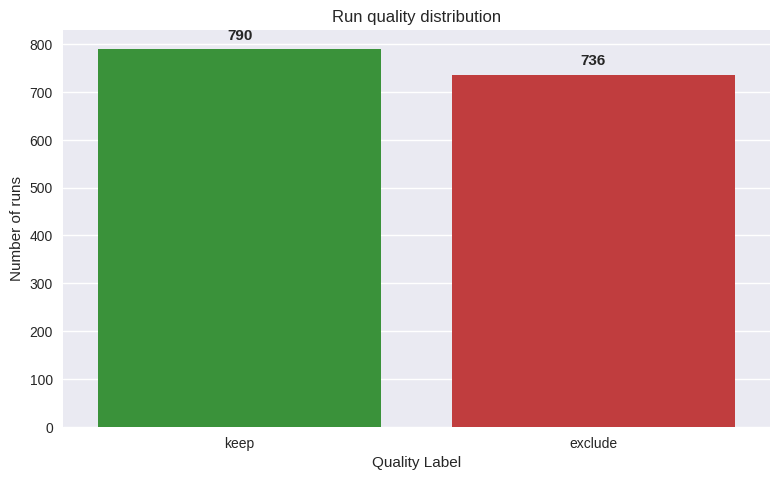

In [27]:
plt.figure(figsize=(8, 5))
sns.barplot(data=quality_counts, x='label', y='count', palette=['#2ca02c', '#d62728'])
plt.title('Run quality distribution')
plt.ylabel('Number of runs')
plt.xlabel('Quality Label')
for i, row in quality_counts.iterrows():
    plt.text(i, row['count'] + 20, f"{row['count']}", ha='center', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

In [28]:
MIN_GOOD_RUNS = 10
MIN_GOOD_RATIO = 0.70

subject_quality = (
    RUN_DF.groupby('subject')
          .agg(
              total_runs=('run', 'count'),
              bad_runs=('bad_run', 'sum'),
              avg_clip_fraction=('clip_fraction_over_200uv', 'mean'),
              max_clip_fraction=('clip_fraction_over_200uv', 'max'),
              median_std_uv=('mean_channel_std_uv', 'median'),
              min_std_uv=('mean_channel_std_uv', 'min'),
              max_std_uv=('mean_channel_std_uv', 'max'),
              flat_runs=('has_flat_issue', 'sum'),
              noisy_runs=('has_noisy_issue', 'sum'),
              total_events=('events_total', 'sum'),
              total_label_1=('events_label_1', 'sum'),
              total_label_2=('events_label_2', 'sum')
          )
          .assign(
              good_runs=lambda df: df['total_runs'] - df['bad_runs'],
              good_ratio=lambda df: df['good_runs'] / df['total_runs']
          )
)

subject_quality['is_good_subject'] = (
    (subject_quality['good_runs'] >= MIN_GOOD_RUNS)
    & (subject_quality['good_ratio'] >= MIN_GOOD_RATIO)
)

print(f"\nSubject quality thresholds:")
print(f"  - Minimum good runs: {MIN_GOOD_RUNS}")
print(f"  - Minimum good ratio: {MIN_GOOD_RATIO}")
print(f"\nSubject statistics:")
print(f"  - Total subjects: {len(subject_quality)}")
print(f"  - Good subjects: {subject_quality['is_good_subject'].sum()}")
print(f"  - Bad subjects: {(~subject_quality['is_good_subject']).sum()}")
subject_quality.sort_values('good_ratio', ascending=False).head(10)


Subject quality thresholds:
  - Minimum good runs: 10
  - Minimum good ratio: 0.7

Subject statistics:
  - Total subjects: 109
  - Good subjects: 51
  - Bad subjects: 58


,total_runs,bad_runs,avg_clip_fraction,max_clip_fraction,median_std_uv,min_std_uv,max_std_uv,flat_runs,noisy_runs,total_events,total_label_1,total_label_2,good_runs,good_ratio,is_good_subject
subject,,,,,,,,,,,,,,,
S089,14,0,0.000,0.000,12.027,10.125,13.984,0,0,378,98,91,14,1.000,True
S093,14,0,0.003,0.008,34.679,29.251,39.605,0,0,362,92,88,14,1.000,True
S011,14,0,0.001,0.002,30.276,26.373,35.526,0,0,362,89,91,14,1.000,True
S016,14,0,0.005,0.011,38.583,20.116,44.086,0,0,362,91,89,14,1.000,True
S020,14,0,0.000,0.001,22.214,17.048,47.849,0,0,362,88,92,14,1.000,True
S074,14,0,0.000,0.000,18.093,14.299,33.653,0,0,362,92,88,14,1.000,True
S073,14,0,0.000,0.005,18.571,16.557,36.247,0,0,362,90,90,14,1.000,True
S030,14,0,0.001,0.011,25.045,19.760,58.674,0,0,362,92,88,14,1.000,True
S062,14,0,0.005,0.028,37.702,24.924,54.753,0,0,362,91,89,14,1.000,True


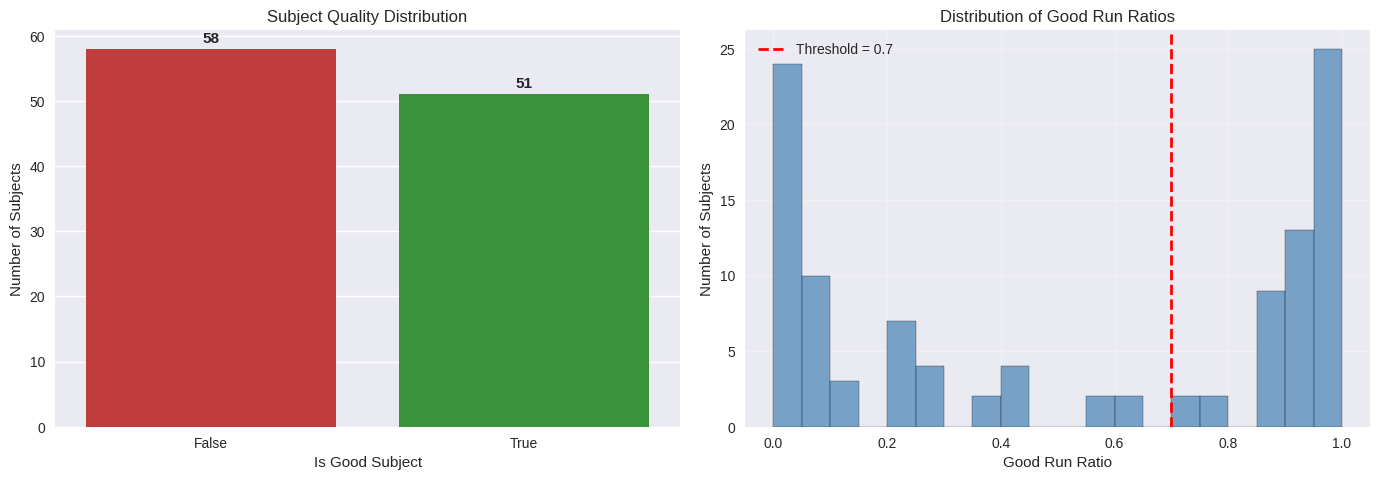

,is_good,subjects
0,False,58
1,True,51


In [29]:
summary_counts = subject_quality['is_good_subject'].value_counts().rename_axis('is_good').reset_index(name='subjects')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=summary_counts, x='is_good', y='subjects', palette=['#d62728', '#2ca02c'], ax=axes[0])
axes[0].set_title('Subject Quality Distribution')
axes[0].set_xlabel('Is Good Subject')
axes[0].set_ylabel('Number of Subjects')
for i, row in summary_counts.iterrows():
    axes[0].text(i, row['subjects'] + 1, f"{row['subjects']}", ha='center', fontsize=11, fontweight='bold')

axes[1].hist(subject_quality['good_ratio'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(MIN_GOOD_RATIO, color='red', linestyle='--', linewidth=2, label=f'Threshold = {MIN_GOOD_RATIO}')
axes[1].set_title('Distribution of Good Run Ratios')
axes[1].set_xlabel('Good Run Ratio')
axes[1].set_ylabel('Number of Subjects')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

summary_counts

In [30]:
good_subjects = subject_quality[subject_quality['is_good_subject']].index.tolist()
good_runs_df = RUN_DF.loc[(~RUN_DF['bad_run']) & (RUN_DF['subject'].isin(good_subjects))].copy()

print(f"Retained {len(good_subjects)} subjects with at least {MIN_GOOD_RUNS} clean runs each.")
print(f"Retained {good_runs_df.shape[0]} runs across retained subjects.")
print(f"Total runs filtered out: {len(RUN_DF) - len(good_runs_df)}")
print(f"\nGood runs by category:")
print(good_runs_df.groupby('category')['run'].count())
print(f"\nEvent distribution in good runs:")
print(f"  - Total events: {good_runs_df['events_total'].sum()}")
print(f"  - Label 1 events: {good_runs_df['events_label_1'].sum()}")
print(f"  - Label 2 events: {good_runs_df['events_label_2'].sum()}")

good_runs_df[['subject', 'run', 'category', 'task', 'mean_channel_std_uv', 'clip_fraction_over_200uv']].head(10)

Retained 51 subjects with at least 10 clean runs each.
Retained 669 runs across retained subjects.
Total runs filtered out: 857

Good runs by category:
category
motor_execution    292
motor_imagery      295
resting_state       82
Name: run, dtype: int64

Event distribution in good runs:
  - Total events: 17804
  - Label 1 events: 4441
  - Label 2 events: 4421


,subject,run,category,task,mean_channel_std_uv,clip_fraction_over_200uv
0,S001,R01,resting_state,Baseline eyes open,56.077,0.011
1,S001,R02,resting_state,Baseline eyes closed,52.818,0.001
3,S001,R04,motor_execution,Open/close right fist (executed),52.817,0.003
4,S001,R05,motor_execution,Open/close both fists (executed),55.645,0.008
5,S001,R06,motor_execution,Open/close both feet (executed),66.178,0.021
6,S001,R07,motor_imagery,Imagine left fist,55.639,0.010
7,S001,R08,motor_imagery,Imagine right fist,50.815,0.004
8,S001,R09,motor_imagery,Imagine both fists,58.918,0.011
9,S001,R10,motor_imagery,Imagine both feet,54.463,0.006
10,S001,R11,motor_execution,Alternate fists and feet (executed),66.935,0.018


In [31]:
GOOD_RUNS_PATH = DERIVED_DIR / 'physionet_good_runs.csv'
GOOD_SUBJECTS_PATH = DERIVED_DIR / 'physionet_good_subjects.csv'
ALL_RUNS_WITH_FLAGS_PATH = DERIVED_DIR / 'physionet_all_runs_with_flags.csv'

good_runs_df.sort_values(['subject', 'run']).to_csv(GOOD_RUNS_PATH, index=False)
subject_quality.reset_index().to_csv(GOOD_SUBJECTS_PATH, index=False)
RUN_DF.sort_values(['subject', 'run']).to_csv(ALL_RUNS_WITH_FLAGS_PATH, index=False)

print(f"Saved cleaned run inventory -> {GOOD_RUNS_PATH}")
print(f"  - Total good runs: {len(good_runs_df)}")
print(f"\nSaved subject summary -> {GOOD_SUBJECTS_PATH}")
print(f"  - Total subjects analyzed: {len(subject_quality)}")
print(f"  - Good subjects: {subject_quality['is_good_subject'].sum()}")
print(f"\nSaved all runs with quality flags -> {ALL_RUNS_WITH_FLAGS_PATH}")
print(f"  - Total runs: {len(RUN_DF)}")
print(f"\nCleaning complete!")

Saved cleaned run inventory -> /kaggle/working/derived/physionet_good_runs.csv
  - Total good runs: 669

Saved subject summary -> /kaggle/working/derived/physionet_good_subjects.csv
  - Total subjects analyzed: 109
  - Good subjects: 51

Saved all runs with quality flags -> /kaggle/working/derived/physionet_all_runs_with_flags.csv
  - Total runs: 1526

Cleaning complete!


In [32]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Mean Channel Std by Category',
        'Clip Fraction Distribution',
        'Z-Score Distribution',
        'Bad Runs by Category'
    ),
    specs=[[{'type': 'box'}, {'type': 'histogram'}],
           [{'type': 'histogram'}, {'type': 'bar'}]]
)

for category in RUN_DF['category'].unique():
    cat_data = RUN_DF[RUN_DF['category'] == category]
    fig.add_trace(
        go.Box(y=cat_data['mean_channel_std_uv'], name=category),
        row=1, col=1
    )

fig.add_trace(
    go.Histogram(x=RUN_DF['clip_fraction_over_200uv'], nbinsx=50, name='Clip Fraction'),
    row=1, col=2
)

fig.add_trace(
    go.Histogram(x=RUN_DF['max_abs_z'], nbinsx=50, name='Z-Score'),
    row=2, col=1
)

bad_by_category = RUN_DF.groupby('category')['bad_run'].sum().reset_index()
fig.add_trace(
    go.Bar(x=bad_by_category['category'], y=bad_by_category['bad_run'], name='Bad Runs'),
    row=2, col=2
)

fig.add_vline(x=CLIP_THRESHOLD, line_dash='dash', line_color='red', row=1, col=2)
fig.add_vline(x=Z_THRESHOLD, line_dash='dash', line_color='red', row=2, col=1)

fig.update_layout(height=800, title_text="Data Quality Analysis Dashboard", showlegend=False)
fig.update_xaxes(title_text="Category", row=1, col=1)
fig.update_yaxes(title_text="Std (uV)", row=1, col=1)
fig.update_xaxes(title_text="Clip Fraction", row=1, col=2)
fig.update_xaxes(title_text="Max Abs Z-Score", row=2, col=1)
fig.update_xaxes(title_text="Category", row=2, col=2)
fig.update_yaxes(title_text="Bad Run Count", row=2, col=2)

fig.show()

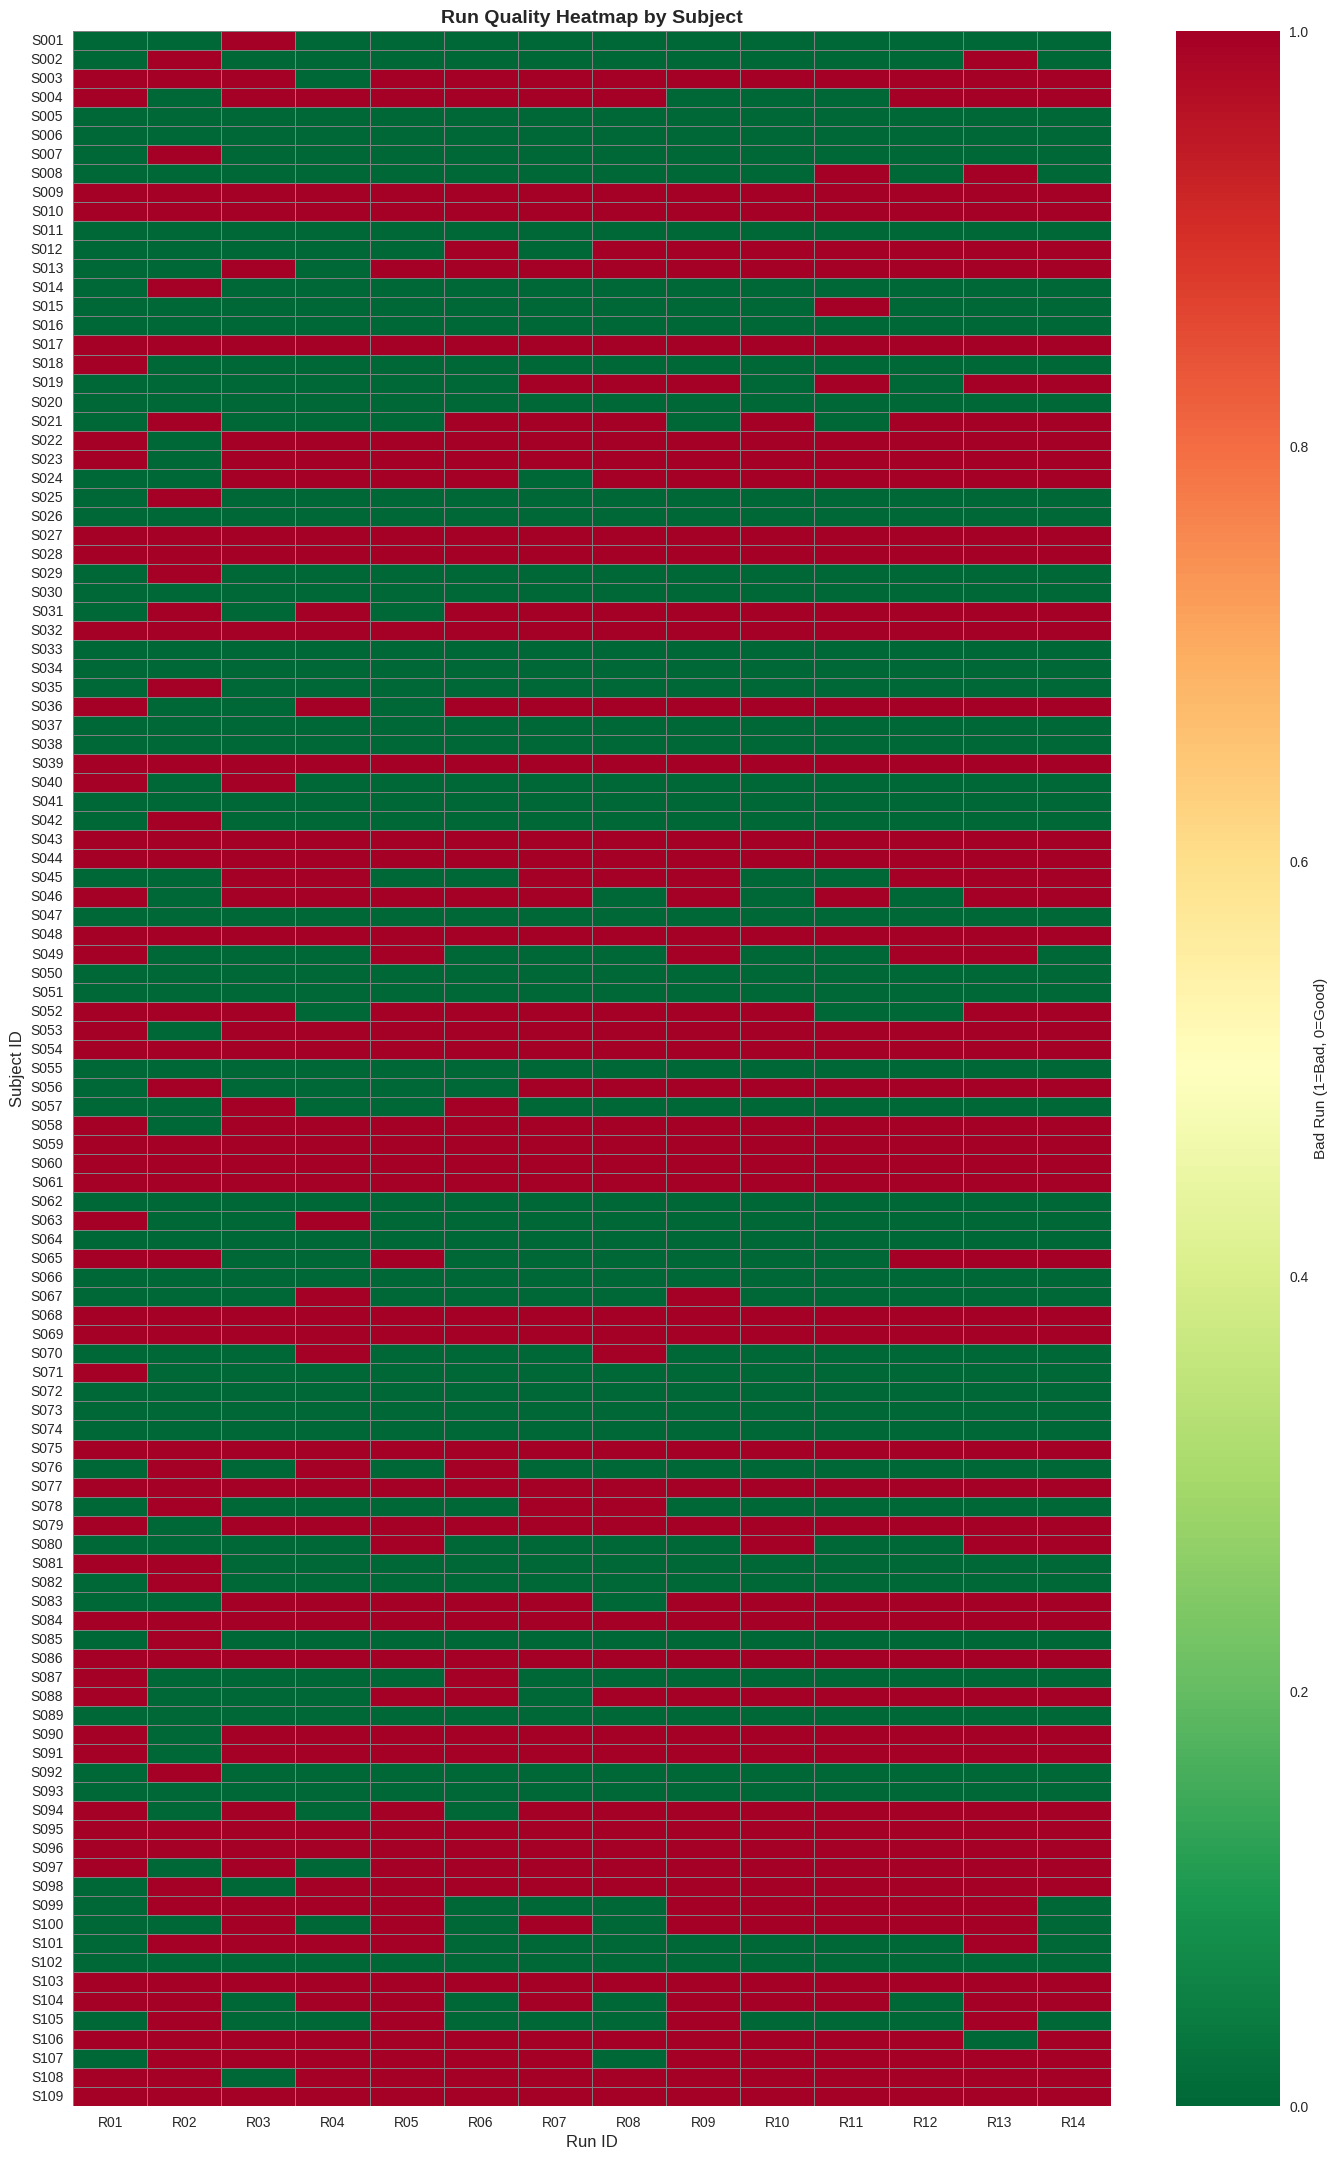


Subjects with most bad runs:
subject
S109   14.000
S084   14.000
S096   14.000
S095   14.000
S086   14.000
S017   14.000
S069   14.000
S068   14.000
S075   14.000
S060   14.000
dtype: float64


In [33]:
run_quality_matrix = RUN_DF.pivot(index='subject', columns='run', values='bad_run').astype(float)

plt.figure(figsize=(14, max(0.2 * len(run_quality_matrix), 10)))
sns.heatmap(
    run_quality_matrix, 
    cmap='RdYlGn_r', 
    cbar_kws={'label': 'Bad Run (1=Bad, 0=Good)'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title('Run Quality Heatmap by Subject', fontsize=14, fontweight='bold')
plt.xlabel('Run ID', fontsize=12)
plt.ylabel('Subject ID', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nSubjects with most bad runs:")
bad_run_counts = run_quality_matrix.sum(axis=1).sort_values(ascending=False)
print(bad_run_counts.head(10))


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less



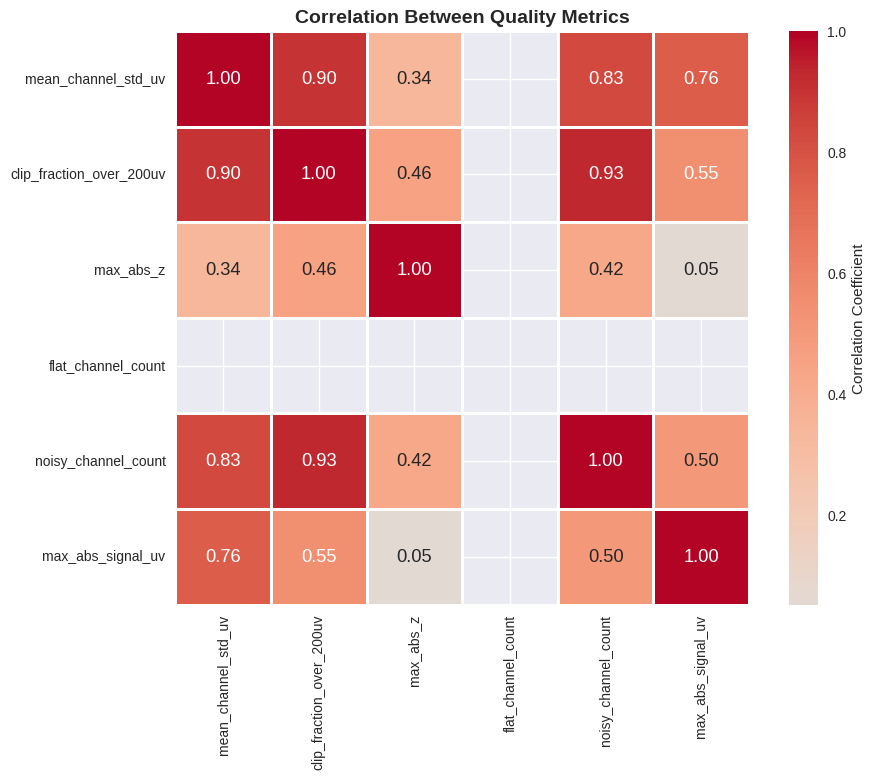


Key correlations:
                     metric1                   metric2  correlation
7   clip_fraction_over_200uv       noisy_channel_count        0.932
0        mean_channel_std_uv  clip_fraction_over_200uv        0.897
3        mean_channel_std_uv       noisy_channel_count        0.832
4        mean_channel_std_uv         max_abs_signal_uv        0.756
8   clip_fraction_over_200uv         max_abs_signal_uv        0.549
14       noisy_channel_count         max_abs_signal_uv        0.503
5   clip_fraction_over_200uv                 max_abs_z        0.458
10                 max_abs_z       noisy_channel_count        0.422
1        mean_channel_std_uv                 max_abs_z        0.343
11                 max_abs_z         max_abs_signal_uv        0.052


In [34]:
quality_metrics = [
    'mean_channel_std_uv', 'clip_fraction_over_200uv', 'max_abs_z',
    'flat_channel_count', 'noisy_channel_count', 'max_abs_signal_uv'
]

corr_matrix = RUN_DF[quality_metrics].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Between Quality Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey correlations:")
corr_pairs = []
for i in range(len(quality_metrics)):
    for j in range(i+1, len(quality_metrics)):
        corr_pairs.append({
            'metric1': quality_metrics[i],
            'metric2': quality_metrics[j],
            'correlation': corr_matrix.iloc[i, j]
        })
        
corr_df = pd.DataFrame(corr_pairs).sort_values('correlation', key=abs, ascending=False)
print(corr_df.head(10))

**DATA PREPROCESSING**

In [35]:
from pathlib import Path
import warnings
import json
from datetime import datetime

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import mne
from mne.preprocessing import ICA

import matplotlib.pyplot as plt
import seaborn as sns

mne.set_log_level('WARNING')
warnings.filterwarnings('ignore', category=RuntimeWarning)

sns.set_context('notebook', font_scale=1.1)
plt.style.use('seaborn-v0_8')

FILES_ROOT = Path("/kaggle/input/eeg-motorimagery-eegmmidb-v1-0-0/physionet.org/files/eegmmidb/1.0.0")
PREPROCESSED_DIR = DERIVED_DIR / 'preprocessed'
PREPROCESSED_DIR.mkdir(parents=True, exist_ok=True)

GOOD_RUNS_PATH = DERIVED_DIR / 'physionet_good_runs.csv'
assert GOOD_RUNS_PATH.exists(), 'Run the cleaning notebook to generate physionet_good_runs.csv first.'

GOOD_RUNS = pd.read_csv(GOOD_RUNS_PATH)
print(f"Loaded {GOOD_RUNS.shape[0]} clean runs spanning {GOOD_RUNS['subject'].nunique()} subjects.")
print(f"\nRun distribution:")
print(GOOD_RUNS.groupby('category')['run'].count())
GOOD_RUNS.head()

Loaded 669 clean runs spanning 51 subjects.

Run distribution:
category
motor_execution    292
motor_imagery      295
resting_state       82
Name: run, dtype: int64


,subject,run,session,category,task,sfreq,n_channels,duration_s,mean_channel_std_uv,median_channel_std_uv,...,band_beta_rel_power_std,band_gamma_rel_power_mean,band_gamma_rel_power_std,has_flat_issue,has_noisy_issue,amp_issue_flag,max_abs_z,zscore_flag,bad_run,quality_label
0,S001,R01,baseline,resting_state,Baseline eyes open,160.000,64,60.994,56.077,52.453,...,0.053,0.020,0.015,False,False,False,0.758,False,False,keep
1,S001,R02,baseline,resting_state,Baseline eyes closed,160.000,64,60.994,52.818,50.629,...,0.039,0.019,0.017,False,False,False,2.512,False,False,keep
2,S001,R04,run_1,motor_execution,Open/close right fist (executed),160.000,64,124.994,52.817,52.675,...,0.051,0.027,0.018,False,False,False,0.708,False,False,keep
3,S001,R05,run_1,motor_execution,Open/close both fists (executed),160.000,64,124.994,55.645,51.974,...,0.061,0.028,0.020,False,False,False,0.760,False,False,keep
4,S001,R06,run_1,motor_execution,Open/close both feet (executed),160.000,64,124.994,66.178,64.862,...,0.035,0.017,0.008,False,False,False,0.561,False,False,keep


In [36]:
PREPROCESSING_CONFIG = {
    'filtering': {
        'l_freq': 0.5,
        'h_freq': 40.0,
        'notch_freqs': [50.0, 100.0],
        'filter_method': 'fir',
        'fir_design': 'firwin'
    },
    'bad_channels': {
        'flat_threshold': 0.5,
        'noisy_std_multiplier': 3.0,
        'max_bad_fraction': 0.15
    },
    'ica': {
        'n_components': 20,
        'method': 'picard',
        'max_iter': 500,
        'random_state': 42
    },
    'resampling': {
        'target_sfreq': 128.0
    },
    'epoching': {
        'tmin': -1.0,
        'tmax': 5.0,
        'baseline': (-0.5, 0),
        'reject_criteria': {'eeg': 100e-6},
        'flat_criteria': {'eeg': 1e-6}
    }
}

print("Preprocessing Configuration:")
print(json.dumps(PREPROCESSING_CONFIG, indent=2))

TARGET_SFREQ = PREPROCESSING_CONFIG['resampling']['target_sfreq']
HP_CUTOFF = PREPROCESSING_CONFIG['filtering']['l_freq']
LP_CUTOFF = PREPROCESSING_CONFIG['filtering']['h_freq']
NOTCH_FREQS = PREPROCESSING_CONFIG['filtering']['notch_freqs']

Preprocessing Configuration:
{
  "filtering": {
    "l_freq": 0.5,
    "h_freq": 40.0,
    "notch_freqs": [
      50.0,
      100.0
    ],
    "filter_method": "fir",
    "fir_design": "firwin"
  },
  "bad_channels": {
    "flat_threshold": 0.5,
    "noisy_std_multiplier": 3.0,
    "max_bad_fraction": 0.15
  },
  "ica": {
    "n_components": 20,
    "method": "picard",
    "max_iter": 500,
    "random_state": 42
  },
  "resampling": {
    "target_sfreq": 128.0
  },
  "epoching": {
    "tmin": -1.0,
    "tmax": 5.0,
    "baseline": [
      -0.5,
      0
    ],
    "reject_criteria": {
      "eeg": 0.0001
    },
    "flat_criteria": {
      "eeg": 1e-06
    }
  }
}


In [37]:
def _edf_path(subject_id: str, run_id: str) -> Path:
    """Get path to EDF file for subject and run."""
    return FILES_ROOT / subject_id / f"{subject_id}{run_id}.edf"


def detect_bad_channels(raw, flat_threshold=0.5, noisy_multiplier=3.0):
    """
    Detect flat and noisy EEG channels.
    
    Parameters
    ----------
    raw : mne.io.Raw
        Raw EEG data
    flat_threshold : float
        Threshold in μV below which channels are considered flat
    noisy_multiplier : float
        Multiplier of mean std to detect noisy channels
        
    Returns
    -------
    bad_channels : list
        List of bad channel names
    """
    data = raw.get_data(picks='eeg') * 1e6
    channel_stds = np.std(data, axis=1)
    mean_std = np.mean(channel_stds)
    
    bad_channels = []
    eeg_ch_names = [raw.ch_names[i] for i in mne.pick_types(raw.info, eeg=True)]
    
    for i, ch_name in enumerate(eeg_ch_names):
        if channel_stds[i] < flat_threshold:
            bad_channels.append(ch_name)
        elif channel_stds[i] > noisy_multiplier * mean_std:
            bad_channels.append(ch_name)
    
    return bad_channels

def preprocess_run(subject_id: str, run_id: str, config: dict, overwrite: bool = False):
    """
    Preprocess a single run with comprehensive quality checks.
    
    FIXED ORDER:
    1. Load data
    2. Detect and interpolate bad channels
    3. Apply notch filter BEFORE resampling (at original sampling rate)
    4. Apply bandpass filter
    5. Apply CAR
    6. Resample to target frequency
    
    Parameters
    ----------
    subject_id : str
        Subject identifier (e.g., 'S001')
    run_id : str
        Run identifier (e.g., 'R03')
    config : dict
        Preprocessing configuration
    overwrite : bool
        Whether to overwrite existing files
        
    Returns
    -------
    output_info : dict
        Dictionary with preprocessing results and metrics
    """
    edf_path = _edf_path(subject_id, run_id)
    if not edf_path.exists():
        raise FileNotFoundError(f"EDF file not found: {edf_path}")
    
    out_dir = PREPROCESSED_DIR / subject_id
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"{subject_id}{run_id}_preproc_raw.fif"
    
    if out_path.exists() and not overwrite:
        return {'status': 'skipped', 'path': out_path}
    
    output_info = {
        'subject': subject_id,
        'run': run_id,
        'status': 'processing',
        'path': out_path,
        'timestamp': datetime.now().isoformat()
    }
    
    try:
        # 1. Load raw data
        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose='ERROR')
        
        cleaned_names = {name: name.rstrip('.') for name in raw.ch_names}
        raw.rename_channels(cleaned_names)
        
        eeg_picks = mne.pick_types(raw.info, eeg=True)
        raw.pick(eeg_picks)
        
        raw.set_montage('standard_1020', on_missing='ignore', match_case=False)
        
        output_info['original_sfreq'] = raw.info['sfreq']
        output_info['n_channels_original'] = len(raw.ch_names)
        output_info['duration_s'] = raw.times[-1]
        
        # 2. Detect and interpolate bad channels
        bad_channels = detect_bad_channels(
            raw, 
            flat_threshold=config['bad_channels']['flat_threshold'],
            noisy_multiplier=config['bad_channels']['noisy_std_multiplier']
        )
        
        output_info['bad_channels'] = bad_channels
        output_info['n_bad_channels'] = len(bad_channels)
        
        if len(bad_channels) > 0:
            raw.info['bads'] = bad_channels
            if len(bad_channels) / len(raw.ch_names) < config['bad_channels']['max_bad_fraction']:
                raw.interpolate_bads(reset_bads=True)
                output_info['bad_channels_interpolated'] = True
            else:
                output_info['bad_channels_interpolated'] = False
                output_info['warning'] = f"Too many bad channels ({len(bad_channels)})"
        
        # 3. Apply notch filter FIRST (at original sampling rate 160 Hz, Nyquist = 80 Hz)
        # This removes 50 Hz powerline noise before resampling
        if config['filtering']['notch_freqs']:
            # Only apply notch frequencies below Nyquist of original sampling rate
            nyquist_original = raw.info['sfreq'] / 2.0
            valid_notch_freqs = [f for f in config['filtering']['notch_freqs'] if f < nyquist_original]
            
            if valid_notch_freqs:
                raw.notch_filter(freqs=valid_notch_freqs, verbose=False)
                output_info['notch_applied'] = valid_notch_freqs
            else:
                output_info['notch_applied'] = []
        
        # 4. Apply bandpass filter
        raw.filter(
            l_freq=config['filtering']['l_freq'],
            h_freq=config['filtering']['h_freq'],
            method=config['filtering']['filter_method'],
            fir_design=config['filtering']['fir_design'],
            verbose=False
        )
        
        # 5. Apply Common Average Reference
        raw.set_eeg_reference('average', projection=False, verbose=False)
        # 6. Resample to target frequency (LAST step)
        raw.resample(config['resampling']['target_sfreq'], npad='auto', verbose=False)
        
        output_info['final_sfreq'] = raw.info['sfreq']
        output_info['n_channels_final'] = len(raw.ch_names)
        
        # Save preprocessed data
        raw.save(out_path, overwrite=True, verbose='ERROR')
        
        output_info['status'] = 'success'
        output_info['file_size_mb'] = out_path.stat().st_size / (1024 * 1024)
        
    except Exception as e:
        output_info['status'] = 'error'
        output_info['error'] = str(e)
    
    return output_info

In [38]:
OVERWRITE = True
PROCESS_SUBSET = None

if PROCESS_SUBSET is not None:
    runs_to_process = GOOD_RUNS.head(PROCESS_SUBSET)
else:
    runs_to_process = GOOD_RUNS

processed_records = []
error_records = []

print(f"Processing {len(runs_to_process)} runs...")
print(f"Overwrite mode: {OVERWRITE}\n")

for _, row in tqdm(runs_to_process.iterrows(), total=len(runs_to_process), desc='Preprocessing'):
    try:
        result = preprocess_run(
            row['subject'], 
            row['run'], 
            PREPROCESSING_CONFIG, 
            overwrite=OVERWRITE
        )
        
        result.update({
            'category': row['category'],
            'task': row.get('task', '')
        })
        
        if result['status'] == 'error':
            error_records.append(result)
        else:
            processed_records.append(result)
    except Exception as e:
        error_records.append({
            'subject': row['subject'],
            'run': row['run'],
            'status': 'error',
            'error': str(e)
        })

processed_df = pd.DataFrame(processed_records)
error_df = pd.DataFrame(error_records)

INDEX_PATH = DERIVED_DIR / 'physionet_preprocessed_index.csv'
processed_df.to_csv(INDEX_PATH, index=False)

if len(error_df) > 0:
    ERROR_PATH = DERIVED_DIR / 'physionet_preprocessing_errors.csv'
    error_df.to_csv(ERROR_PATH, index=False)
    print(f"\nErrors occurred: {len(error_df)}")
    print(f"Error log saved to: {ERROR_PATH}")

print(f"\nPreprocessing complete!")
print(f"  - Successfully processed: {len(processed_df)}")
print(f"  - Errors: {len(error_df)}")
print(f"  - Index saved to: {INDEX_PATH}")

processed_df.head(10)

Processing 669 runs...
Overwrite mode: True



Preprocessing:   0%|          | 0/669 [00:00<?, ?it/s]


Preprocessing complete!
  - Successfully processed: 669
  - Errors: 0
  - Index saved to: /kaggle/working/derived/physionet_preprocessed_index.csv


,subject,run,status,path,timestamp,original_sfreq,n_channels_original,duration_s,bad_channels,n_bad_channels,notch_applied,final_sfreq,n_channels_final,file_size_mb,category,task,bad_channels_interpolated
0,S001,R01,success,/kaggle/working/derived/preprocessed/S001/S001...,2025-10-25T15:20:24.098878,160.000,64,60.994,[],0,[50.0],128.000,64,1.917,resting_state,Baseline eyes open,NaN
1,S001,R02,success,/kaggle/working/derived/preprocessed/S001/S001...,2025-10-25T15:20:24.410386,160.000,64,60.994,[],0,[50.0],128.000,64,1.917,resting_state,Baseline eyes closed,NaN
2,S001,R04,success,/kaggle/working/derived/preprocessed/S001/S001...,2025-10-25T15:20:24.639713,160.000,64,124.994,[],0,[50.0],128.000,64,3.918,motor_execution,Open/close right fist (executed),NaN
3,S001,R05,success,/kaggle/working/derived/preprocessed/S001/S001...,2025-10-25T15:20:25.035023,160.000,64,124.994,[],0,[50.0],128.000,64,3.918,motor_execution,Open/close both fists (executed),NaN
4,S001,R06,success,/kaggle/working/derived/preprocessed/S001/S001...,2025-10-25T15:20:25.416412,160.000,64,124.994,[],0,[50.0],128.000,64,3.918,motor_execution,Open/close both feet (executed),NaN
5,S001,R07,success,/kaggle/working/derived/preprocessed/S001/S001...,2025-10-25T15:20:25.807151,160.000,64,124.994,[],0,[50.0],128.000,64,3.918,motor_imagery,Imagine left fist,NaN
6,S001,R08,success,/kaggle/working/derived/preprocessed/S001/S001...,2025-10-25T15:20:26.180154,160.000,64,124.994,[],0,[50.0],128.000,64,3.918,motor_imagery,Imagine right fist,NaN
7,S001,R09,success,/kaggle/working/derived/preprocessed/S001/S001...,2025-10-25T15:20:26.550624,160.000,64,124.994,[],0,[50.0],128.000,64,3.918,motor_imagery,Imagine both fists,NaN
8,S001,R10,success,/kaggle/working/derived/preprocessed/S001/S001...,2025-10-25T15:20:26.911797,160.000,64,124.994,[],0,[50.0],128.000,64,3.918,motor_imagery,Imagine both feet,NaN
9,S001,R11,success,/kaggle/working/derived/preprocessed/S001/S001...,2025-10-25T15:20:27.285675,160.000,64,124.994,[],0,[50.0],128.000,64,3.918,motor_execution,Alternate fists and feet (executed),NaN


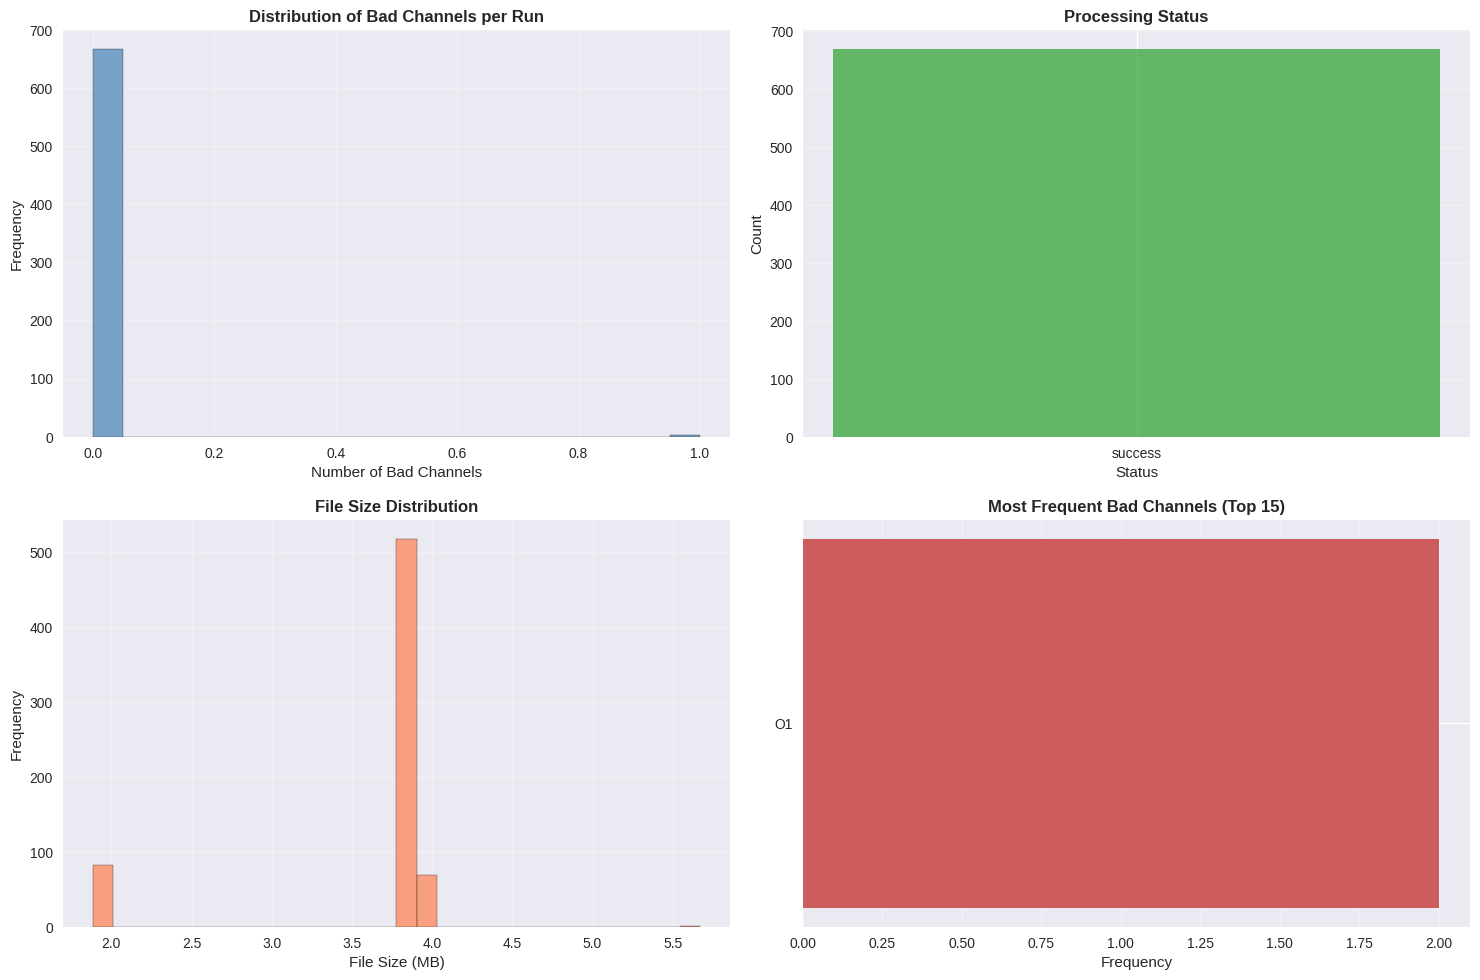


Preprocessing Statistics:
  - Total runs processed: 669
  - Mean bad channels per run: 0.00
  - Median bad channels per run: 0
  - Max bad channels in a run: 1
  - Mean file size: 3.63 MB
  - Total storage used: 2428.39 MB


In [39]:
if len(processed_df) > 0:
    processed_df['bad_channels'] = processed_df['bad_channels'].apply(
        lambda x: eval(x) if isinstance(x, str) else x
    )
    processed_df['n_bad_channels'] = processed_df['bad_channels'].apply(len)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].hist(processed_df['n_bad_channels'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Distribution of Bad Channels per Run', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Number of Bad Channels')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    status_counts = processed_df['status'].value_counts()
    axes[0, 1].bar(status_counts.index, status_counts.values, color=['#2ca02c', '#d62728'], alpha=0.7)
    axes[0, 1].set_title('Processing Status', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Status')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    if 'file_size_mb' in processed_df.columns:
        axes[1, 0].hist(processed_df['file_size_mb'].dropna(), bins=30, color='coral', edgecolor='black', alpha=0.7)
        axes[1, 0].set_title('File Size Distribution', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('File Size (MB)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].grid(True, alpha=0.3)
    
    bad_channel_freq = {}
    for ch_list in processed_df['bad_channels']:
        for ch in ch_list:
            bad_channel_freq[ch] = bad_channel_freq.get(ch, 0) + 1
        if len(bad_channel_freq) > 0:
            sorted_ch = sorted(bad_channel_freq.items(), key=lambda x: x[1], reverse=True)[:15]
            channels, counts = zip(*sorted_ch)
            axes[1, 1].barh(range(len(channels)), counts, color='indianred', alpha=0.7)
            axes[1, 1].set_yticks(range(len(channels)))
            axes[1, 1].set_yticklabels(channels)
            axes[1, 1].set_title('Most Frequent Bad Channels (Top 15)', fontsize=12, fontweight='bold')
            axes[1, 1].set_xlabel('Frequency')
            axes[1, 1].grid(True, alpha=0.3, axis='x')
            axes[1, 1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print("\nPreprocessing Statistics:")
    print(f"  - Total runs processed: {len(processed_df)}")
    print(f"  - Mean bad channels per run: {processed_df['n_bad_channels'].mean():.2f}")
    print(f"  - Median bad channels per run: {processed_df['n_bad_channels'].median():.0f}")
    print(f"  - Max bad channels in a run: {processed_df['n_bad_channels'].max():.0f}")
    if 'file_size_mb' in processed_df.columns:
        print(f"  - Mean file size: {processed_df['file_size_mb'].mean():.2f} MB")
        print(f"  - Total storage used: {processed_df['file_size_mb'].sum():.2f} MB")
else:
    print("No data to visualize yet. Run the preprocessing cell first.")

Loading: S047 - R14
Category: motor_imagery
Task: Alternate fists and feet (imagery, repeat)

Data properties:
  - Sampling rate: 128.0 Hz
  - Number of channels: 64
  - Duration: 122.99 seconds
  - Data shape: (64, 15744)

Visualizing time domain (first 10 seconds)...


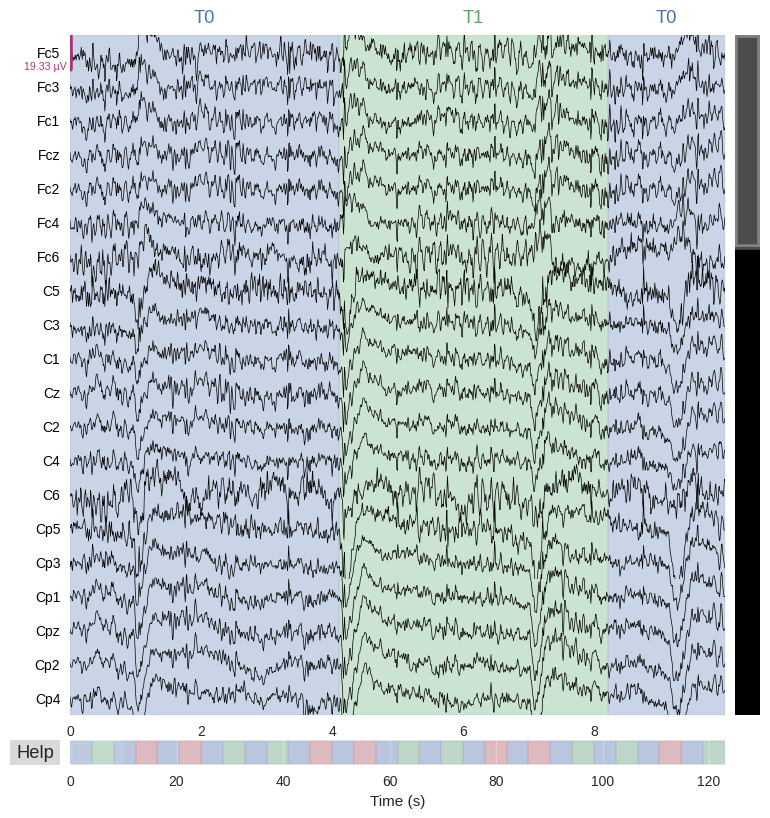


Visualizing power spectral density...


/tmp/ipykernel_19/3488881922.py:34: UserWarning:

The figure layout has changed to tight



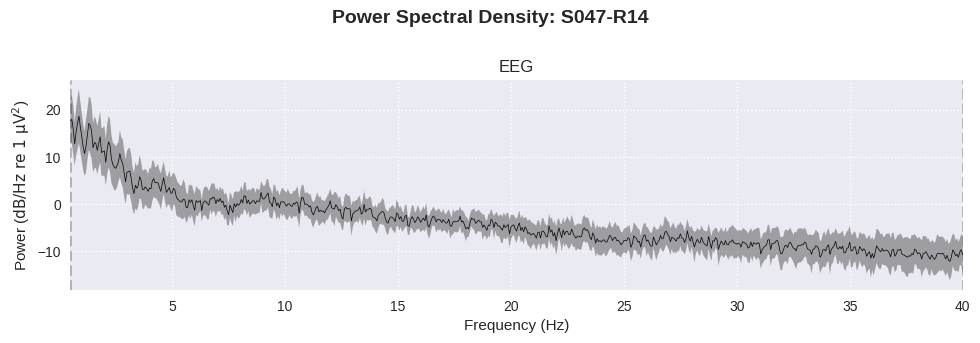


Event Analysis:
  - Total events found: 30
  - Event types: ['T0', 'T1', 'T2']
    - T0: 15 occurrences
    - T1: 8 occurrences
    - T2: 7 occurrences


In [40]:
if len(processed_df) > 0 and processed_df['status'].eq('success').any():
    success_runs = processed_df[processed_df['status'] == 'success']
    example_idx = len(success_runs) // 2
    example_row = success_runs.iloc[example_idx]
    
    example_path = Path(example_row['path'])
    
    if example_path.exists():
        print(f"Loading: {example_row['subject']} - {example_row['run']}")
        print(f"Category: {example_row['category']}")
        print(f"Task: {example_row['task']}")
        
        raw = mne.io.read_raw_fif(example_path, preload=True, verbose='ERROR')
        
        print(f"\nData properties:")
        print(f"  - Sampling rate: {raw.info['sfreq']} Hz")
        print(f"  - Number of channels: {len(raw.ch_names)}")
        print(f"  - Duration: {raw.times[-1]:.2f} seconds")
        print(f"  - Data shape: {raw.get_data().shape}")
        
        # Time domain visualization
        print(f"\nVisualizing time domain (first 10 seconds)...")
        fig1 = raw.plot(duration=10.0, n_channels=20, scalings='auto', 
                       title=f"Time Domain: {example_row['subject']}-{example_row['run']}", 
                       show=False)
        plt.show()
        
        # Power spectral density
        print(f"\nVisualizing power spectral density...")
        fig2 = raw.plot_psd(fmin=0.5, fmax=40, average=True, spatial_colors=False,
                           show=False)
        plt.suptitle(f"Power Spectral Density: {example_row['subject']}-{example_row['run']}", 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        # Event analysis - PhysioNet uses annotations, not stimulus channels
        try:
            events, event_dict = mne.events_from_annotations(raw, verbose='ERROR')
            if len(events) > 0:
                print(f"\nEvent Analysis:")
                print(f"  - Total events found: {len(events)}")
                print(f"  - Event types: {list(event_dict.keys())}")
                for event_name, event_id in event_dict.items():
                    count = (events[:, 2] == event_id).sum()
                    print(f"    - {event_name}: {count} occurrences")
            else:
                print(f"\nNo events found in this run")
        except Exception as e:
            print(f"\nCould not extract events: {str(e)}")
    else:
        print(f"File not found: {example_path}")
else:
    print("No successful preprocessed runs available yet.")

In [41]:
def apply_ica_to_run(raw_path, n_components=20, method='picard', random_state=42):
    """
    Apply ICA to remove artifacts from a preprocessed run.
    
    Parameters
    ----------
    raw_path : Path
        Path to preprocessed FIF file
    n_components : int
        Number of ICA components
    method : str
        ICA method ('picard', 'fastica', 'infomax')
    random_state : int
        Random seed for reproducibility
        
    Returns
    -------
    raw_clean : mne.io.Raw
        Cleaned raw data
    ica : mne.preprocessing.ICA
        Fitted ICA object
    """
    raw = mne.io.read_raw_fif(raw_path, preload=True, verbose='ERROR')
    
    ica = ICA(
        n_components=n_components,
        method=method,
        max_iter=500,
        random_state=random_state
    )
    
    raw_for_ica = raw.copy().filter(l_freq=1.0, h_freq=None, verbose=False)
    
    ica.fit(raw_for_ica)
    explained_var = ica.get_explained_variance_ratio(raw_for_ica)
    print(f"ICA explained variance: {explained_var['eeg']:.1%}")
    
    raw_clean = ica.apply(raw.copy())
    
    return raw_clean, ica

APPLY_ICA_DEMO = False

if APPLY_ICA_DEMO and len(processed_df) > 0:
    success_runs = processed_df[processed_df['status'] == 'success']
    if len(success_runs) > 0:
        example_path = Path(success_runs.iloc[0]['path'])
        
        print(f"Applying ICA to: {example_path.name}")
        
        raw_clean, ica = apply_ica_to_run(
            example_path,
            n_components=PREPROCESSING_CONFIG['ica']['n_components'],
            method=PREPROCESSING_CONFIG['ica']['method'],
            random_state=PREPROCESSING_CONFIG['ica']['random_state']
        )
        
        print(f"\nICA Components fitted: {ica.n_components_}")
        print(f"Method: {ica.method}")
        
        fig = ica.plot_components(picks=range(min(20, ica.n_components_)), show=False)
        plt.suptitle('ICA Component Topographies (First 20)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        fig = ica.plot_sources(raw_clean, start=0, stop=10, show=False)
        plt.tight_layout()
        plt.show()
        print("\nTo apply ICA to all runs, implement a batch ICA function similar to preprocess_run()")
else:
    print("Set APPLY_ICA_DEMO = True to run ICA demonstration on a sample file.")

Set APPLY_ICA_DEMO = True to run ICA demonstration on a sample file.


**MULTI GCN**


models.py


In [42]:
%%writefile models.py

"""
EEG-ARNN Model Architecture
Implements the 3-fold TFEM-CARM architecture from the paper.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class TFEM(nn.Module):
    """
    Temporal Feature Extraction Module
    Uses 1D temporal convolution to extract time-domain features
    """
    def __init__(self, in_channels, out_channels, kernel_size=16, pool_size=2, use_pool=True):
        super(TFEM, self).__init__()
        self.use_pool = use_pool

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(1, kernel_size),
            padding=(0, kernel_size // 2),
            bias=False
        )

        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ELU()

        if use_pool:
            self.pool = nn.AvgPool2d(kernel_size=(1, pool_size))

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)

        if self.use_pool:
            x = self.pool(x)

        return x


class CARM(nn.Module):
    """
    Channel Active Reasoning Module
    Learns channel connectivity via graph convolution

    Implements the proper GCN formula from the paper:
    H = D_tilde^(-1/2) * W_tilde * D_tilde^(-1/2) * X * Theta

    Where:
        W_tilde = W* + I (add self-loops)
        D_tilde = degree matrix
        X = input features
        Theta = learnable weights
    """
    def __init__(self, num_channels, hidden_dim=40):
        super(CARM, self).__init__()
        self.num_channels = num_channels
        self.hidden_dim = hidden_dim

        # Learnable adjacency matrix W*
        self.W = nn.Parameter(torch.FloatTensor(num_channels, num_channels))
        nn.init.xavier_uniform_(self.W)

        # Learnable transformation theta (for graph convolution)
        self.theta = nn.Linear(hidden_dim, hidden_dim, bias=False)

        self.bn = nn.BatchNorm2d(hidden_dim)
        self.activation = nn.ELU()

    def forward(self, x):
        """
        Args:
            x: (batch_size, hidden_dim, num_channels, time_steps)

        Returns:
            out: (batch_size, hidden_dim, num_channels, time_steps)
            A_sym: Symmetric adjacency matrix
        """
        batch_size, hidden_dim, num_channels, time_steps = x.size()

        # 1. Get symmetric adjacency matrix
        A = torch.sigmoid(self.W)
        A_sym = (A + A.t()) / 2

        # 2. Add self-loops: W_tilde = W* + I
        I = torch.eye(num_channels, device=x.device)
        A_tilde = A_sym + I

        # 3. Compute degree matrix D_tilde
        D_tilde = torch.diag(A_tilde.sum(dim=1))

        # 4. Compute normalized adjacency: D^(-1/2) * A_tilde * D^(-1/2)
        D_inv_sqrt = torch.pow(D_tilde, -0.5)
        D_inv_sqrt[torch.isinf(D_inv_sqrt)] = 0.0
        A_norm = D_inv_sqrt @ A_tilde @ D_inv_sqrt

        # 5. Apply graph convolution on channel dimension
        # Reshape: (batch, hidden_dim, num_channels, time) -> (batch, time, num_channels, hidden_dim)
        x_reshaped = x.permute(0, 3, 2, 1)  # (batch, time, channels, features)

        # Reshape to (batch * time, num_channels, hidden_dim)
        x_flat = x_reshaped.contiguous().view(batch_size * time_steps, num_channels, hidden_dim)

        # Graph aggregation: (num_channels, num_channels) @ (batch*time, num_channels, hidden_dim)
        x_graph = torch.matmul(A_norm, x_flat)  # (batch*time, num_channels, hidden_dim)

        # Apply learnable transformation Theta
        x_graph = self.theta(x_graph)  # (batch*time, num_channels, hidden_dim)

        # Reshape back: (batch*time, num_channels, hidden_dim) -> (batch, time, num_channels, hidden_dim)
        x_graph = x_graph.view(batch_size, time_steps, num_channels, hidden_dim)

        # Permute back: (batch, time, num_channels, hidden_dim) -> (batch, hidden_dim, num_channels, time)
        out = x_graph.permute(0, 3, 2, 1)

        # 6. Batch normalization and activation
        out = self.bn(out)
        out = self.activation(out)

        return out, A_sym

    def get_adjacency_matrix(self):
        """Get the learned adjacency matrix"""
        with torch.no_grad():
            A = torch.sigmoid(self.W)
            A_sym = (A + A.t()) / 2
        return A_sym.cpu().numpy()


class EEGARNN(nn.Module):
    """
    Complete EEG-ARNN Architecture
    3-fold TFEM-CARM with final classification layer
    """
    def __init__(self, num_channels=64, num_timepoints=512, num_classes=4, hidden_dim=40):
        super(EEGARNN, self).__init__()

        self.num_channels = num_channels
        self.num_timepoints = num_timepoints
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim

        self.tfem1 = TFEM(in_channels=1, out_channels=hidden_dim, kernel_size=16, use_pool=False)
        self.carm1 = CARM(num_channels=num_channels, hidden_dim=hidden_dim)

        self.tfem2 = TFEM(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=16, pool_size=2, use_pool=True)
        self.carm2 = CARM(num_channels=num_channels, hidden_dim=hidden_dim)

        self.tfem3 = TFEM(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=16, pool_size=2, use_pool=True)
        self.carm3 = CARM(num_channels=num_channels, hidden_dim=hidden_dim)

        test_input = torch.zeros(1, 1, num_channels, num_timepoints)
        with torch.no_grad():
            out = self._forward_features(test_input)
            flattened_size = out.view(1, -1).size(1)

        self.fc1 = nn.Linear(flattened_size, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

        self.adjacency_matrices = {}

    def _forward_features(self, x):
        x = self.tfem1(x)
        x, A1 = self.carm1(x)

        x = self.tfem2(x)
        x, A2 = self.carm2(x)

        x = self.tfem3(x)
        x, A3 = self.carm3(x)

        self.adjacency_matrices = {'A1': A1, 'A2': A2, 'A3': A3}

        return x

    def forward(self, x):
        x = self._forward_features(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

    def get_final_adjacency_matrix(self):
        """Get the final learned adjacency matrix from CARM3"""
        return self.carm3.get_adjacency_matrix()

    def get_all_adjacency_matrices(self):
        """Get all adjacency matrices from all CARM layers"""
        return {
            'A1': self.carm1.get_adjacency_matrix(),
            'A2': self.carm2.get_adjacency_matrix(),
            'A3': self.carm3.get_adjacency_matrix()
        }


class ChannelSelector:
    """
    Channel selection using learned adjacency matrix
    Implements both Edge Selection (ES) and Aggregation Selection (AS)
    """
    def __init__(self, adjacency_matrix, channel_names):
        """
        Parameters
        ----------
        adjacency_matrix : np.ndarray
            Learned adjacency matrix (num_channels, num_channels)
        channel_names : list
            List of channel names
        """
        self.adj_matrix = adjacency_matrix
        self.channel_names = np.array(channel_names)
        self.num_channels = len(channel_names)

    def edge_selection(self, k):
        """
        Edge Selection (ES) method
        Selects channels based on strongest pairwise connections

        Parameters
        ----------
        k : int
            Number of edges to select

        Returns
        -------
        selected_channels : list
            List of selected channel names
        selected_indices : np.ndarray
            Indices of selected channels
        """
        edges = []
        for i in range(self.num_channels):
            for j in range(i+1, self.num_channels):
                edge_importance = abs(self.adj_matrix[i, j]) + abs(self.adj_matrix[j, i])
                edges.append((i, j, edge_importance))

        sorted_edges = sorted(edges, key=lambda x: x[2], reverse=True)

        top_k_edges = sorted_edges[:k]

        selected_indices = set()
        for i, j, _ in top_k_edges:
            selected_indices.add(i)
            selected_indices.add(j)

        selected_indices = np.array(sorted(selected_indices))
        selected_channels = self.channel_names[selected_indices].tolist()

        return selected_channels, selected_indices

    def aggregation_selection(self, k):
        """
        Aggregation Selection (AS) method
        Selects channels based on aggregate connection strength

        Parameters
        ----------
        k : int
            Number of channels to select

        Returns
        -------
        selected_channels : list
            List of selected channel names
        selected_indices : np.ndarray
            Indices of selected channels
        """
        channel_scores = np.sum(np.abs(self.adj_matrix), axis=1)

        selected_indices = np.argsort(channel_scores)[-k:]
        selected_indices = np.sort(selected_indices)

        selected_channels = self.channel_names[selected_indices].tolist()

        return selected_channels, selected_indices

    def visualize_adjacency(self, save_path=None):
        """Visualize the adjacency matrix"""
        import matplotlib.pyplot as plt
        import seaborn as sns

        fig, ax = plt.subplots(figsize=(12, 10))
        sns.heatmap(
            self.adj_matrix,
            xticklabels=self.channel_names,
            yticklabels=self.channel_names,
            cmap='RdYlGn',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={'label': 'Connection Strength'},
            ax=ax
        )
        ax.set_title('Learned Channel Adjacency Matrix', fontsize=14, fontweight='bold')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        return fig

Writing models.py


train_utils


In [43]:
%%writefile train_utils.py

"""
Training utilities for EEG-ARNN
Includes data loading, training loops, evaluation metrics
"""

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import mne
from pathlib import Path
from tqdm.auto import tqdm


class EEGDataset(Dataset):
    """PyTorch Dataset for EEG data"""
    def __init__(self, data, labels):
        """
        Parameters
        ----------
        data : np.ndarray
            EEG data of shape (n_trials, n_channels, n_timepoints)
        labels : np.ndarray
            Labels of shape (n_trials,)
        """
        self.data = torch.FloatTensor(data).unsqueeze(1)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


def load_preprocessed_data(fif_path, tmin=-1.0, tmax=5.0, baseline=(-0.5, 0)):
    """
    Load preprocessed FIF file and extract epochs

    Parameters
    ----------
    fif_path : Path
        Path to preprocessed FIF file
    tmin : float
        Start time of epoch
    tmax : float
        End time of epoch
    baseline : tuple
        Baseline correction window

    Returns
    -------
    data : np.ndarray
        Epoched data (n_epochs, n_channels, n_timepoints)
    labels : np.ndarray
        Event labels (n_epochs,)
    """
    raw = mne.io.read_raw_fif(fif_path, preload=True, verbose='ERROR')

    # Try to find events from stim channels first
    try:
        events = mne.find_events(raw, verbose='ERROR')
        if len(events) == 0:
            return None, None
        event_ids = {f'T{i}': i for i in np.unique(events[:, 2])}
    except ValueError:
        # If no stim channels, try to get events from annotations
        events, event_ids = mne.events_from_annotations(raw, verbose='ERROR')
        if len(events) == 0:
            return None, None

    epochs = mne.Epochs(
        raw, events,
        event_id=event_ids,
        tmin=tmin, tmax=tmax,
        baseline=baseline,
        preload=True,
        verbose='ERROR'
    )

    data = epochs.get_data()
    labels = epochs.events[:, 2]

    return data, labels


def filter_classes(data, labels, selected_classes):
    """
    Filter data to include only selected classes

    Parameters
    ----------
    data : np.ndarray
        EEG data
    labels : np.ndarray
        Labels
    selected_classes : list
        List of class IDs to keep

    Returns
    -------
    filtered_data : np.ndarray
    filtered_labels : np.ndarray
        Labels remapped to 0, 1, 2, ...
    """
    mask = np.isin(labels, selected_classes)
    filtered_data = data[mask]
    filtered_labels = labels[mask]

    label_mapping = {old: new for new, old in enumerate(selected_classes)}
    filtered_labels = np.array([label_mapping[label] for label in filtered_labels])

    return filtered_data, filtered_labels


def normalize_data(data):
    """
    Z-score normalization per channel

    Parameters
    ----------
    data : np.ndarray
        Shape (n_trials, n_channels, n_timepoints)

    Returns
    -------
    normalized_data : np.ndarray
        Z-score normalized data
    """
    mean = data.mean(axis=(0, 2), keepdims=True)
    std = data.std(axis=(0, 2), keepdims=True) + 1e-8
    return (data - mean) / std


def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for data, labels in dataloader:
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy, all_preds, all_labels


def train_model(model, train_loader, val_loader, device, epochs=100, lr=0.001, patience=15):
    """
    Complete training loop with early stopping

    Parameters
    ----------
    model : nn.Module
        EEG-ARNN model
    train_loader : DataLoader
        Training data loader
    val_loader : DataLoader
        Validation data loader
    device : torch.device
        Device to train on
    epochs : int
        Maximum number of epochs
    lr : float
        Learning rate
    patience : int
        Early stopping patience

    Returns
    -------
    history : dict
        Training history
    best_model_state : dict
        State dict of best model
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=False
    )

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

    model.load_state_dict(best_model_state)

    return history, best_model_state


def cross_validate_subject(data, labels, num_channels, num_timepoints, num_classes,
                          device, n_splits=3, epochs=30, lr=0.001, batch_size=64, patience=8):
    """
    Perform k-fold cross-validation for a single subject

    Parameters
    ----------
    data : np.ndarray
        EEG data (n_trials, n_channels, n_timepoints)
    labels : np.ndarray
        Labels (n_trials,)
    num_channels : int
        Number of EEG channels
    num_timepoints : int
        Number of time points
    num_classes : int
        Number of classes
    device : torch.device
        Device to train on
    n_splits : int
        Number of CV folds
    epochs : int
        Max epochs per fold
    lr : float
        Learning rate

    Returns
    -------
    results : dict
        Cross-validation results
    """
    from models import EEGARNN

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_results = []
    adjacency_matrices = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(data, labels)):
        print(f"  Fold {fold+1}/{n_splits}", end=" ", flush=True)

        X_train, X_val = data[train_idx], data[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]

        X_train = normalize_data(X_train)
        X_val = normalize_data(X_val)

        train_dataset = EEGDataset(X_train, y_train)
        val_dataset = EEGDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

        model = EEGARNN(
            num_channels=num_channels,
            num_timepoints=num_timepoints,
            num_classes=num_classes,
            hidden_dim=40
        ).to(device)

        history, best_state = train_model(
            model, train_loader, val_loader, device,
            epochs=epochs, lr=lr, patience=patience
        )

        model.load_state_dict(best_state)
        _, val_acc, val_preds, val_labels = evaluate(
            model, val_loader, nn.CrossEntropyLoss(), device
        )

        adj_matrix = model.get_final_adjacency_matrix()
        adjacency_matrices.append(adj_matrix)

        print(f"-> Acc: {val_acc:.3f} (stopped at epoch {len(history['val_acc'])})")

        fold_results.append({
            'fold': fold,
            'val_acc': val_acc,
            'history': history,
            'preds': val_preds,
            'labels': val_labels
        })

    avg_adjacency = np.mean(adjacency_matrices, axis=0)

    return {
        'fold_results': fold_results,
        'avg_accuracy': np.mean([r['val_acc'] for r in fold_results]),
        'std_accuracy': np.std([r['val_acc'] for r in fold_results]),
        'adjacency_matrix': avg_adjacency
    }


def retrain_with_selected_channels(data, labels, selected_channel_indices, num_timepoints, num_classes,
                                   device, n_splits=3, epochs=25, lr=0.001, batch_size=64, patience=6):
    """
    Retrain model using only selected channels
    
    Parameters
    ----------
    data : np.ndarray
        Full EEG data (n_trials, n_channels, n_timepoints)
    labels : np.ndarray
        Labels (n_trials,)
    selected_channel_indices : np.ndarray
        Indices of channels to keep
    num_timepoints : int
        Number of time points
    num_classes : int
        Number of classes
    device : torch.device
        Device to train on
    n_splits : int
        Number of CV folds
    epochs : int
        Max epochs per fold
    lr : float
        Learning rate
        
    Returns
    -------
    results : dict
        Cross-validation results with selected channels
    """
    from models import EEGARNN
    
    # Select only the specified channels
    data_subset = data[:, selected_channel_indices, :]
    num_channels_subset = len(selected_channel_indices)
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(data_subset, labels)):
        X_train, X_val = data_subset[train_idx], data_subset[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        X_train = normalize_data(X_train)
        X_val = normalize_data(X_val)
        
        train_dataset = EEGDataset(X_train, y_train)
        val_dataset = EEGDataset(X_val, y_val)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        model = EEGARNN(
            num_channels=num_channels_subset,
            num_timepoints=num_timepoints,
            num_classes=num_classes,
            hidden_dim=40
        ).to(device)
        
        history, best_state = train_model(
            model, train_loader, val_loader, device,
            epochs=epochs, lr=lr, patience=patience
        )
        
        model.load_state_dict(best_state)
        _, val_acc, val_preds, val_labels = evaluate(
            model, val_loader, nn.CrossEntropyLoss(), device
        )
        
        fold_results.append({
            'fold': fold,
            'val_acc': val_acc,
            'history': history
        })
    
    return {
        'fold_results': fold_results,
        'avg_accuracy': np.mean([r['val_acc'] for r in fold_results]),
        'std_accuracy': np.std([r['val_acc'] for r in fold_results])
    }

Writing train_utils.py


In [44]:
import sys
from pathlib import Path
import warnings
import json
from datetime import datetime
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import mne

from train_utils import (
    load_preprocessed_data, filter_classes, normalize_data,
    EEGDataset
)

warnings.filterwarnings('ignore')
mne.set_log_level('ERROR')
sns.set_context('notebook', font_scale=1.1)
plt.style.use('seaborn-v0_8')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla P100-PCIE-16GB


In [45]:
CONFIG = {
    'data': {
        'preprocessed_dir': Path('/kaggle/working/derived/preprocessed'),
        'index_file': Path('/kaggle/working/derived/physionet_preprocessed_index.csv'),
        'selected_classes': [1, 2],
        'tmin': -1.0,
        'tmax': 5.0,
        'baseline': (-0.5, 0)
    },
    'training': {
        'epochs': 20,
        'learning_rate': 0.001,
        'batch_size': 32,
        'n_folds': 2
    },
    'subjects': ['S001', 'S002', 'S005', 'S006', 'S007'],
    'output_dir': Path('/kaggle/working/results/architecture_variants')
}

CONFIG['output_dir'].mkdir(parents=True, exist_ok=True)
print(json.dumps(CONFIG, indent=2, default=str))


{
  "data": {
    "preprocessed_dir": "/kaggle/working/derived/preprocessed",
    "index_file": "/kaggle/working/derived/physionet_preprocessed_index.csv",
    "selected_classes": [
      1,
      2
    ],
    "tmin": -1.0,
    "tmax": 5.0,
    "baseline": [
      -0.5,
      0
    ]
  },
  "training": {
    "epochs": 20,
    "learning_rate": 0.001,
    "batch_size": 32,
    "n_folds": 2
  },
  "subjects": [
    "S001",
    "S002",
    "S005",
    "S006",
    "S007"
  ],
  "output_dir": "/kaggle/working/results/architecture_variants"
}


In [46]:
class MultiLayerCARM(nn.Module):
    """
    Multi-layer Graph Convolution for CARM
    Each layer can see further connections in the graph
    
    Parameters
    ----------
    num_channels : int
        Number of EEG channels
    hidden_dim : int
        Hidden dimension
    num_layers : int
        Number of GCN layers (1, 2, or 3)
    share_adjacency : bool
        If True, all layers share the same adjacency matrix
        If False, each layer learns its own adjacency
    """
    def __init__(self, num_channels, hidden_dim=40, num_layers=2, share_adjacency=True):
        super(MultiLayerCARM, self).__init__()
        
        self.num_channels = num_channels
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.share_adjacency = share_adjacency
        
        # Learnable adjacency matrix(ces)
        if share_adjacency:
            self.W = nn.Parameter(torch.FloatTensor(num_channels, num_channels))
            nn.init.xavier_uniform_(self.W)
        else:
            self.W_list = nn.ParameterList([
                nn.Parameter(torch.FloatTensor(num_channels, num_channels))
                for _ in range(num_layers)
            ])
            for W in self.W_list:
                nn.init.xavier_uniform_(W)
        
        # GCN layers
        self.gcn_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim, bias=False)
            for _ in range(num_layers)
        ])
        
        # Batch norm for each layer
        self.bn_layers = nn.ModuleList([
            nn.BatchNorm2d(hidden_dim)
            for _ in range(num_layers)
        ])
        
        self.activation = nn.ELU()
    
    def get_normalized_adjacency(self, W_param, device):
        """
        Compute normalized adjacency matrix: D^(-1/2) * A_tilde * D^(-1/2)
        """
        # Symmetric adjacency
        A = torch.sigmoid(W_param)
        A_sym = (A + A.t()) / 2
        
        # Add self-loops
        I = torch.eye(self.num_channels, device=device)
        A_tilde = A_sym + I
        
        # Degree normalization
        D_tilde = torch.diag(A_tilde.sum(dim=1))
        D_inv_sqrt = torch.pow(D_tilde, -0.5)
        D_inv_sqrt[torch.isinf(D_inv_sqrt)] = 0.0
        
        A_norm = D_inv_sqrt @ A_tilde @ D_inv_sqrt
        
        return A_norm, A_sym
    
    def forward(self, x):
        """
        x: (batch, hidden_dim, num_channels, num_timepoints)
        """
        batch_size = x.size(0)
        hidden_dim = x.size(1)
        num_channels = x.size(2)
        time_steps = x.size(3)
        
        # Get adjacency matrices
        if self.share_adjacency:
            A_norm, A_sym = self.get_normalized_adjacency(self.W, x.device)
            adj_matrices = [A_norm] * self.num_layers
        else:
            adj_matrices = []
            A_sym = None
            for W in self.W_list:
                A_norm, A_sym_i = self.get_normalized_adjacency(W, x.device)
                adj_matrices.append(A_norm)
                if A_sym is None:
                    A_sym = A_sym_i  # Return first adjacency
        
        # Reshape for graph convolution: (batch * time, channels, hidden_dim)
        x_reshaped = x.permute(0, 3, 2, 1)  # (batch, time, channels, hidden)
        x_flat = x_reshaped.contiguous().view(batch_size * time_steps, num_channels, hidden_dim)
        
        # Apply multi-layer GCN
        h = x_flat
        for layer_idx in range(self.num_layers):
            # Graph convolution: A_norm @ H @ Theta
            h = torch.matmul(adj_matrices[layer_idx], h)
            h = self.gcn_layers[layer_idx](h)
            
            # Reshape back for batch norm
            h_reshaped = h.view(batch_size, time_steps, num_channels, hidden_dim)
            h_reshaped = h_reshaped.permute(0, 3, 2, 1)  # (batch, hidden, channels, time)
            h_reshaped = self.bn_layers[layer_idx](h_reshaped)
            h_reshaped = self.activation(h_reshaped)
            
            # Reshape back to flat for next layer
            if layer_idx < self.num_layers - 1:
                h_reshaped = h_reshaped.permute(0, 3, 2, 1)
                h = h_reshaped.contiguous().view(batch_size * time_steps, num_channels, hidden_dim)
        
        return h_reshaped, A_sym

In [47]:
class ResidualMultiLayerCARM(nn.Module):
    """
    Multi-layer GCN with residual connections
    Helps gradient flow and prevents degradation
    """
    def __init__(self, num_channels, hidden_dim=40, num_layers=2):
        super(ResidualMultiLayerCARM, self).__init__()
        
        self.num_channels = num_channels
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Shared adjacency
        self.W = nn.Parameter(torch.FloatTensor(num_channels, num_channels))
        nn.init.xavier_uniform_(self.W)
        
        # GCN layers
        self.gcn_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim, bias=False)
            for _ in range(num_layers)
        ])
        
        self.bn_layers = nn.ModuleList([
            nn.BatchNorm2d(hidden_dim)
            for _ in range(num_layers)
        ])
        
        self.activation = nn.ELU()
    
    def get_normalized_adjacency(self, device):
        A = torch.sigmoid(self.W)
        A_sym = (A + A.t()) / 2
        I = torch.eye(self.num_channels, device=device)
        A_tilde = A_sym + I
        D_tilde = torch.diag(A_tilde.sum(dim=1))
        D_inv_sqrt = torch.pow(D_tilde, -0.5)
        D_inv_sqrt[torch.isinf(D_inv_sqrt)] = 0.0
        A_norm = D_inv_sqrt @ A_tilde @ D_inv_sqrt
        return A_norm, A_sym
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden_dim = x.size(1)
        num_channels = x.size(2)
        time_steps = x.size(3)
        
        A_norm, A_sym = self.get_normalized_adjacency(x.device)
        
        # Reshape
        x_reshaped = x.permute(0, 3, 2, 1)
        h = x_reshaped.contiguous().view(batch_size * time_steps, num_channels, hidden_dim)
        
        # Store input for residual
        h_input = h
        
        for layer_idx in range(self.num_layers):
            # Graph convolution
            h = torch.matmul(A_norm, h)
            h = self.gcn_layers[layer_idx](h)
            
            # Add residual connection every 2 layers or at the end
            if layer_idx > 0 and layer_idx % 2 == 1:
                h = h + h_input
            
            # Batch norm and activation
            h_reshaped = h.view(batch_size, time_steps, num_channels, hidden_dim)
            h_reshaped = h_reshaped.permute(0, 3, 2, 1)
            h_reshaped = self.bn_layers[layer_idx](h_reshaped)
            h_reshaped = self.activation(h_reshaped)
            
            if layer_idx < self.num_layers - 1:
                h_reshaped = h_reshaped.permute(0, 3, 2, 1)
                h = h_reshaped.contiguous().view(batch_size * time_steps, num_channels, hidden_dim)
        
        return h_reshaped, A_sym

In [48]:
class TFEM(nn.Module):
    """
    Temporal Feature Extraction Module
    1D CNN across time dimension
    """
    def __init__(self, num_channels, hidden_dim=40, in_channels=None):
        super(TFEM, self).__init__()
        
        self.num_channels = num_channels
        self.hidden_dim = hidden_dim
        
        # If in_channels not specified, assume first block (1 channel input)
        if in_channels is None:
            in_channels = 1
        
        self.in_channels = in_channels
        self.conv = nn.Conv2d(in_channels, hidden_dim, (1, 5), padding=(0, 2))
        self.bn = nn.BatchNorm2d(hidden_dim)
        self.activation = nn.ELU()
    
    def forward(self, x):
        """
        x: (batch, channels, timepoints) or (batch, hidden_dim, channels, timepoints)
        """
        if x.dim() == 3:
            # First block: add channel dimension
            x = x.unsqueeze(1)  # (batch, 1, channels, time)
        
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        
        return x

In [49]:
class EEGARNNVariant(nn.Module):
    """
    Flexible EEG-ARNN that supports different configurations
    
    Parameters
    ----------
    variant : str
        - 'baseline': 3x (TFEM + 1-layer CARM)
        - 'multi2': 3x (TFEM + 2-layer CARM)
        - 'multi3': 3x (TFEM + 3-layer CARM)
        - 'wider': 3x (TFEM + 1-layer CARM) with hidden_dim=60
        - 'deeper': 5x (TFEM + 1-layer CARM)
        - 'residual': 3x (TFEM + 2-layer Residual CARM)
    """
    def __init__(self, num_channels, num_timepoints, num_classes, variant='baseline'):
        super(EEGARNNVariant, self).__init__()
        
        self.variant = variant
        self.num_channels = num_channels
        
        # Set architecture parameters
        if variant == 'baseline':
            hidden_dim = 40
            num_blocks = 3
            gcn_layers = 1
            use_residual = False
        elif variant == 'multi2':
            hidden_dim = 40
            num_blocks = 3
            gcn_layers = 2
            use_residual = False
        elif variant == 'multi3':
            hidden_dim = 40
            num_blocks = 3
            gcn_layers = 3
            use_residual = False
        elif variant == 'wider':
            hidden_dim = 60
            num_blocks = 3
            gcn_layers = 1
            use_residual = False
        elif variant == 'deeper':
            hidden_dim = 40
            num_blocks = 5
            gcn_layers = 1
            use_residual = False
        elif variant == 'residual':
            hidden_dim = 40
            num_blocks = 3
            gcn_layers = 2
            use_residual = True
        else:
            raise ValueError(f"Unknown variant: {variant}")
        
        self.hidden_dim = hidden_dim
        self.num_blocks = num_blocks
        
        # Build TFEM-CARM blocks
        self.tfem_blocks = nn.ModuleList()
        self.carm_blocks = nn.ModuleList()
        
        for i in range(num_blocks):
            # First TFEM has 1 input channel, rest have hidden_dim input channels
            in_channels = 1 if i == 0 else hidden_dim
            self.tfem_blocks.append(TFEM(num_channels, hidden_dim, in_channels=in_channels))
            
            if use_residual:
                self.carm_blocks.append(
                    ResidualMultiLayerCARM(num_channels, hidden_dim, num_layers=gcn_layers)
                )
            else:
                # Use MultiLayerCARM for all variants (including single-layer)
                self.carm_blocks.append(
                    MultiLayerCARM(num_channels, hidden_dim, num_layers=gcn_layers)
                )
        
        # Global pooling and classifier
        self.pool = nn.AdaptiveAvgPool2d((num_channels, 1))
        self.fc = nn.Linear(hidden_dim * num_channels, num_classes)
    
    def forward(self, x):
        """
        x: (batch, channels, timepoints)
        """
        adjacency_matrices = []
        
        for i in range(self.num_blocks):
            # TFEM
            x = self.tfem_blocks[i](x)
            
            # CARM
            x, adj = self.carm_blocks[i](x)
            adjacency_matrices.append(adj)
        
        # Pool and classify
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        # Return last adjacency matrix for channel selection
        return x, adjacency_matrices[-1]

In [50]:
def load_subject_data(subject_id, config):
    """
    Load all motor runs for a subject
    """
    index_df = pd.read_csv(config['data']['index_file'])
    success_df = index_df[index_df['status'] == 'success']
    motor_runs = success_df[success_df['category'].isin(['motor_execution', 'motor_imagery'])]
    
    subject_runs = motor_runs[motor_runs['subject'] == subject_id]
    
    all_data = []
    all_labels = []
    
    for _, run_info in subject_runs.iterrows():
        fif_path = Path(run_info['path'])
        
        if not fif_path.exists():
            continue
        
        try:
            data, labels = load_preprocessed_data(
                fif_path,
                tmin=config['data']['tmin'],
                tmax=config['data']['tmax'],
                baseline=config['data']['baseline']
            )
            
            if data is not None and len(data) > 0:
                all_data.append(data)
                all_labels.append(labels)
                
        except Exception as e:
            print(f"Error loading {fif_path.name}: {e}")
            continue
    
    if len(all_data) == 0:
        return None, None
    
    all_data = np.concatenate(all_data, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    # Filter to selected classes
    all_data, all_labels = filter_classes(
        all_data, all_labels, config['data']['selected_classes']
    )
    
    return all_data, all_labels

In [51]:
def train_variant(variant_name, data, labels, config, device):
    """
    Train a specific architecture variant with cross-validation
    
    Returns
    -------
    results : dict
        Mean accuracy, std, training time, adjacency matrix
    """
    from sklearn.model_selection import StratifiedKFold
    
    num_channels = data.shape[1]
    num_timepoints = data.shape[2]
    num_classes = len(np.unique(labels))
    
    skf = StratifiedKFold(n_splits=config['training']['n_folds'], shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_times = []
    final_adjacency = None
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(data, labels), 1):
        print(f"    Fold {fold_idx}/{config['training']['n_folds']}...", end=' ')
        
        start_time = time.time()
        
        X_train, X_val = data[train_idx], data[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Create model
        model = EEGARNNVariant(
            num_channels=num_channels,
            num_timepoints=num_timepoints,
            num_classes=num_classes,
            variant=variant_name
        ).to(device)
        
        # Data loaders
        train_dataset = EEGDataset(X_train, y_train)
        val_dataset = EEGDataset(X_val, y_val)
        
        train_loader = DataLoader(train_dataset, batch_size=config['training']['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config['training']['batch_size'], shuffle=False)
        
        # Training
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=config['training']['learning_rate'])
        
        best_val_acc = 0.0
        best_epoch = 0
        
        for epoch in range(config['training']['epochs']):
            # Train
            model.train()
            for batch_data, batch_labels in train_loader:
                batch_data = batch_data.to(device).float()
                batch_labels = batch_labels.to(device).long()
                
                optimizer.zero_grad()
                outputs, _ = model(batch_data)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
            
            # Validate
            model.eval()
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for batch_data, batch_labels in val_loader:
                    batch_data = batch_data.to(device).float()
                    batch_labels = batch_labels.to(device).long()
                    
                    outputs, adj = model(batch_data)
                    _, predicted = torch.max(outputs, 1)
                    
                    val_total += batch_labels.size(0)
                    val_correct += (predicted == batch_labels).sum().item()
            
            val_acc = val_correct / val_total
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_epoch = epoch + 1
                final_adjacency = adj.detach().cpu().numpy()
        
        fold_time = time.time() - start_time
        fold_accuracies.append(best_val_acc)
        fold_times.append(fold_time)
        
        print(f"Acc: {best_val_acc:.4f} (epoch {best_epoch}), Time: {fold_time:.1f}s")
    
    return {
        'mean_accuracy': np.mean(fold_accuracies),
        'std_accuracy': np.std(fold_accuracies),
        'mean_time': np.mean(fold_times),
        'fold_accuracies': fold_accuracies,
        'adjacency_matrix': final_adjacency
    }

In [52]:
# Define TOP 3 variants to test (reduced from 6)
variants = {
    'baseline': '3x (TFEM + 1-layer CARM)',
    'multi2': '3x (TFEM + 2-layer CARM) - 2 hops',
    'multi3': '3x (TFEM + 3-layer CARM) - 3 hops'
}

all_results = []

for subject_id in tqdm(CONFIG['subjects'], desc='Processing subjects'):
    print(f"\n{'='*80}")
    print(f"Subject: {subject_id}")
    print(f"{'='*80}")
    
    # Load data
    data, labels = load_subject_data(subject_id, CONFIG)
    
    if data is None or len(data) < 30:
        print(f"Skipping {subject_id}: insufficient data")
        continue
    
    print(f"Data shape: {data.shape}")
    print(f"Labels: {np.unique(labels, return_counts=True)}")
    
    # Test each variant
    for variant_name, variant_desc in variants.items():
        print(f"\n  Variant: {variant_name} - {variant_desc}")
        
        results = train_variant(variant_name, data, labels, CONFIG, device)
        
        print(f"  Final: {results['mean_accuracy']:.4f} ± {results['std_accuracy']:.4f}")
        print(f"  Avg time per fold: {results['mean_time']:.1f}s")
        
        all_results.append({
            'subject': subject_id,
            'variant': variant_name,
            'description': variant_desc,
            'accuracy': results['mean_accuracy'],
            'std': results['std_accuracy'],
            'time': results['mean_time']
        })

results_df = pd.DataFrame(all_results)
print(f"\n{'='*80}")
print("All variants tested!")
print(f"{'='*80}")

Processing subjects:   0%|          | 0/5 [00:00<?, ?it/s]


Subject: S001
Data shape: (231, 64, 769)
Labels: (array([0, 1]), array([154,  77]))

  Variant: baseline - 3x (TFEM + 1-layer CARM)
    Fold 1/2... Acc: 0.3362 (epoch 1), Time: 38.3s
    Fold 2/2... Acc: 0.6696 (epoch 2), Time: 32.2s
  Final: 0.5029 ± 0.1667
  Avg time per fold: 35.2s

  Variant: multi2 - 3x (TFEM + 2-layer CARM) - 2 hops
    Fold 1/2... Acc: 0.6638 (epoch 1), Time: 47.0s
    Fold 2/2... Acc: 0.6696 (epoch 1), Time: 47.2s
  Final: 0.6667 ± 0.0029
  Avg time per fold: 47.1s

  Variant: multi3 - 3x (TFEM + 3-layer CARM) - 3 hops
    Fold 1/2... Acc: 0.6638 (epoch 1), Time: 62.0s
    Fold 2/2... Acc: 0.6696 (epoch 15), Time: 62.2s
  Final: 0.6667 ± 0.0029
  Avg time per fold: 62.1s

Subject: S002
Data shape: (231, 64, 769)
Labels: (array([0, 1]), array([154,  77]))

  Variant: baseline - 3x (TFEM + 1-layer CARM)
    Fold 1/2... Acc: 0.6638 (epoch 1), Time: 32.1s
    Fold 2/2... Acc: 0.6696 (epoch 1), Time: 32.2s
  Final: 0.6667 ± 0.0029
  Avg time per fold: 32.1s

  Vari

In [53]:
if len(results_df) > 0:
    # Aggregate by variant
    summary = results_df.groupby(['variant', 'description']).agg({
        'accuracy': ['mean', 'std'],
        'time': 'mean'
    }).round(4)
    
    summary.columns = ['Mean Accuracy', 'Std Accuracy', 'Mean Time (s)']
    summary = summary.sort_values('Mean Accuracy', ascending=False)
    
    print("\n" + "="*80)
    print("ARCHITECTURE VARIANT COMPARISON")
    print("="*80)
    display(summary)
    
    # Find best variant
    best_variant = summary['Mean Accuracy'].idxmax()[0]
    best_acc = summary['Mean Accuracy'].max()
    baseline_acc = summary.loc[('baseline', variants['baseline']), 'Mean Accuracy']
    improvement = (best_acc - baseline_acc) / baseline_acc * 100
    
    print(f"\nBest variant: {best_variant} ({best_acc:.4f})")
    print(f"Baseline: {baseline_acc:.4f}")
    print(f"Improvement: {improvement:+.2f}%")
    
    # Save results
    results_path = CONFIG['output_dir'] / 'variant_results.csv'
    results_df.to_csv(results_path, index=False)
    print(f"\nResults saved to: {results_path}")
    
    summary_path = CONFIG['output_dir'] / 'variant_summary.csv'
    summary.to_csv(summary_path)
    print(f"Summary saved to: {summary_path}")
else:
    print("No results to summarize.")


ARCHITECTURE VARIANT COMPARISON


,,Mean Accuracy,Std Accuracy,Mean Time (s)
variant,description,,,
multi2,3x (TFEM + 2-layer CARM) - 2 hops,0.667,0.000,49.364
multi3,3x (TFEM + 3-layer CARM) - 3 hops,0.667,0.000,65.167
baseline,3x (TFEM + 1-layer CARM),0.634,0.073,34.186



Best variant: multi2 (0.6667)
Baseline: 0.6339
Improvement: +5.17%

Results saved to: /kaggle/working/results/architecture_variants/variant_results.csv
Summary saved to: /kaggle/working/results/architecture_variants/variant_summary.csv


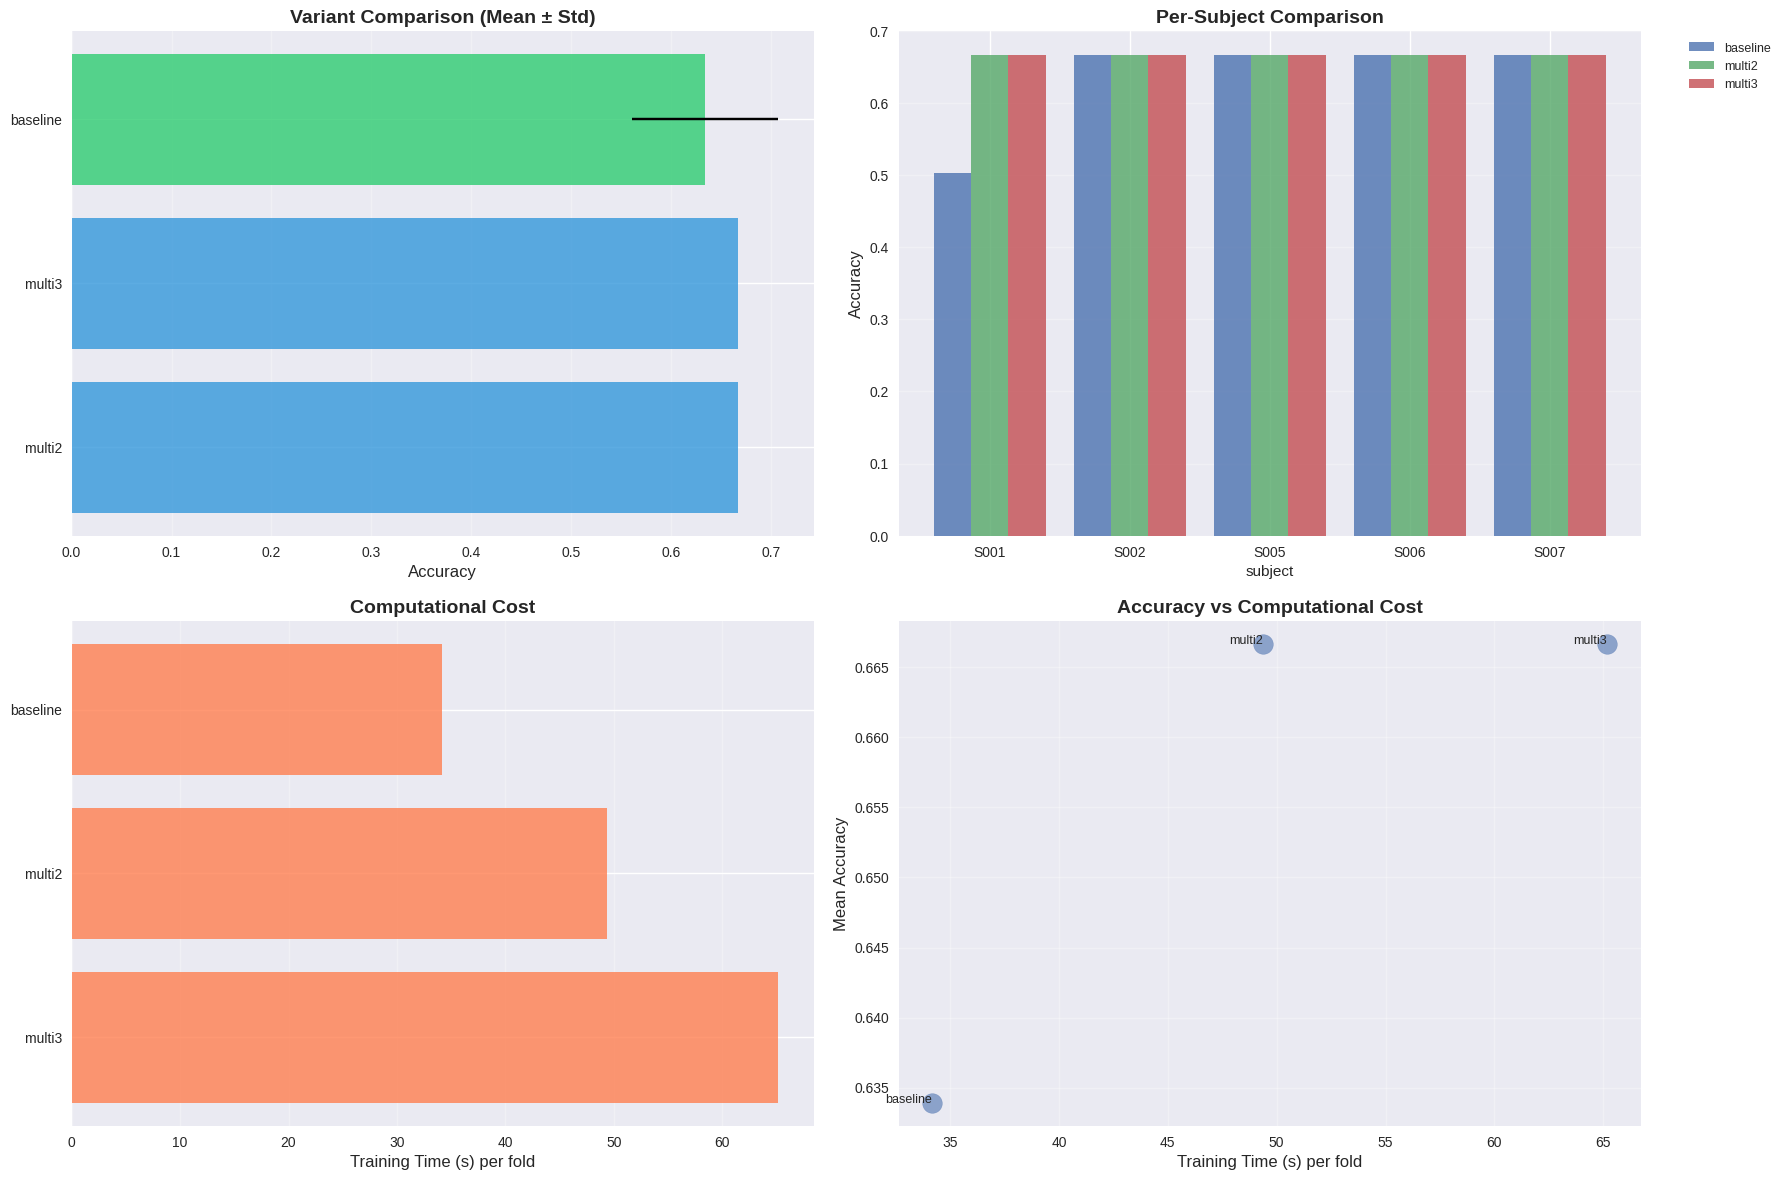


Visualization saved to: /kaggle/working/results/architecture_variants/variant_comparison.png


In [54]:
if len(results_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Mean accuracy comparison
    variant_summary = results_df.groupby('variant').agg({
        'accuracy': ['mean', 'std']
    }).reset_index()
    variant_summary.columns = ['variant', 'mean', 'std']
    variant_summary = variant_summary.sort_values('mean', ascending=False)
    
    colors = ['#2ecc71' if v == 'baseline' else '#3498db' for v in variant_summary['variant']]
    
    axes[0, 0].barh(variant_summary['variant'], variant_summary['mean'],
                    xerr=variant_summary['std'], color=colors, alpha=0.8, capsize=5)
    axes[0, 0].set_xlabel('Accuracy', fontsize=12)
    axes[0, 0].set_title('Variant Comparison (Mean ± Std)', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3, axis='x')
    
    # 2. Per-subject comparison
    pivot = results_df.pivot(index='subject', columns='variant', values='accuracy')
    pivot.plot(kind='bar', ax=axes[0, 1], rot=0, alpha=0.8, width=0.8)
    axes[0, 1].set_ylabel('Accuracy', fontsize=12)
    axes[0, 1].set_title('Per-Subject Comparison', fontsize=14, fontweight='bold')
    axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 3. Training time comparison
    time_summary = results_df.groupby('variant')['time'].mean().sort_values(ascending=False)
    axes[1, 0].barh(time_summary.index, time_summary.values, color='coral', alpha=0.8)
    axes[1, 0].set_xlabel('Training Time (s) per fold', fontsize=12)
    axes[1, 0].set_title('Computational Cost', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='x')
    
    # 4. Accuracy vs Time trade-off
    tradeoff = results_df.groupby('variant').agg({
        'accuracy': 'mean',
        'time': 'mean'
    }).reset_index()
    
    axes[1, 1].scatter(tradeoff['time'], tradeoff['accuracy'], s=200, alpha=0.6)
    for _, row in tradeoff.iterrows():
        axes[1, 1].annotate(row['variant'], (row['time'], row['accuracy']),
                           fontsize=9, ha='right')
    axes[1, 1].set_xlabel('Training Time (s) per fold', fontsize=12)
    axes[1, 1].set_ylabel('Mean Accuracy', fontsize=12)
    axes[1, 1].set_title('Accuracy vs Computational Cost', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    fig_path = CONFIG['output_dir'] / 'variant_comparison.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nVisualization saved to: {fig_path}")
else:
    print("No results to visualize.")

In [55]:
from scipy import stats

if len(results_df) > 0:
    print("\n" + "="*80)
    print("STATISTICAL SIGNIFICANCE (Paired t-test vs Baseline)")
    print("="*80)
    
    baseline_accs = results_df[results_df['variant'] == 'baseline'].sort_values('subject')['accuracy'].values
    
    stat_results = []
    
    for variant in results_df['variant'].unique():
        if variant != 'baseline':
            variant_accs = results_df[results_df['variant'] == variant].sort_values('subject')['accuracy'].values
            
            if len(variant_accs) == len(baseline_accs):
                t_stat, p_value = stats.ttest_rel(variant_accs, baseline_accs)
                
                mean_diff = np.mean(variant_accs - baseline_accs)
                pct_improvement = (mean_diff / np.mean(baseline_accs)) * 100
                
                significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
                
                stat_results.append({
                    'Variant': variant,
                    'Mean Diff': mean_diff,
                    'Improvement (%)': pct_improvement,
                    't-statistic': t_stat,
                    'p-value': p_value,
                    'Significance': significance
                })
    
    stat_df = pd.DataFrame(stat_results)
    stat_df = stat_df.sort_values('Improvement (%)', ascending=False)
    
    # Format for display
    stat_df_display = stat_df.copy()
    stat_df_display['Mean Diff'] = stat_df_display['Mean Diff'].apply(lambda x: f"{x:.4f}")
    stat_df_display['Improvement (%)'] = stat_df_display['Improvement (%)'].apply(lambda x: f"{x:+.2f}%")
    stat_df_display['t-statistic'] = stat_df_display['t-statistic'].apply(lambda x: f"{x:.3f}")
    stat_df_display['p-value'] = stat_df_display['p-value'].apply(lambda x: f"{x:.4f}")
    
    display(stat_df_display)
    
    print("\nSignificance codes: *** p<0.001, ** p<0.01, * p<0.05, ns: not significant")
    
    stat_path = CONFIG['output_dir'] / 'statistical_significance.csv'
    stat_df.to_csv(stat_path, index=False)
    print(f"\nStatistical results saved to: {stat_path}")
else:
    print("No results for statistical testing.")


STATISTICAL SIGNIFICANCE (Paired t-test vs Baseline)


,Variant,Mean Diff,Improvement (%),t-statistic,p-value,Significance
0,multi2,0.0328,+5.17%,1.000,0.3739,ns
1,multi3,0.0328,+5.17%,1.000,0.3739,ns



Significance codes: *** p<0.001, ** p<0.01, * p<0.05, ns: not significant

Statistical results saved to: /kaggle/working/results/architecture_variants/statistical_significance.csv


In [56]:
if len(results_df) > 0:
    # Recompute summary statistics for the report
    summary = results_df.groupby(['variant', 'description']).agg({
        'accuracy': ['mean', 'std'],
        'time': 'mean'
    }).round(4)
    
    summary.columns = ['Mean Accuracy', 'Std Accuracy', 'Mean Time (s)']
    summary = summary.sort_values('Mean Accuracy', ascending=False)
    
    # Find best variant
    best_variant = summary['Mean Accuracy'].idxmax()[0]
    best_acc = summary['Mean Accuracy'].max()
    baseline_acc = summary.loc[('baseline', variants['baseline']), 'Mean Accuracy']
    improvement = (best_acc - baseline_acc) / baseline_acc * 100
    
    # Generate report
    report = []
    report.append("# Architecture Variant Analysis Report\n")
    report.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    report.append("## Objective\n")
    report.append("Evaluate architectural improvements to EEG-ARNN to find optimal configuration.\n\n")
    
    report.append("## Variants Tested\n\n")
    for variant_name, variant_desc in variants.items():
        report.append(f"- **{variant_name}**: {variant_desc}\n")
    report.append("\n")
    
    report.append("## Results\n\n")
    for idx, row in summary.iterrows():
        variant_name = idx[0]
        report.append(f"**{variant_name}**\n")
        report.append(f"- Accuracy: {row['Mean Accuracy']:.4f} +/- {row['Std Accuracy']:.4f}\n")
        report.append(f"- Time: {row['Mean Time (s)']:.1f}s per fold\n\n")
    
    report.append("## Key Findings\n\n")
    report.append(f"1. **Best variant**: {best_variant} ({best_acc:.4f})\n")
    report.append(f"2. **Baseline**: {baseline_acc:.4f}\n")
    report.append(f"3. **Improvement**: {improvement:+.2f}%\n\n")
    
    report.append("## Recommendations\n\n")
    if improvement > 2:
        report.append(f"The **{best_variant}** architecture shows significant improvement over baseline. ")
        report.append("Recommend using this configuration for final experiments.\n")
    elif improvement > 0:
        report.append(f"The **{best_variant}** architecture shows modest improvement. ")
        report.append("Consider trade-off with computational cost.\n")
    else:
        report.append("No variant significantly outperforms baseline. ")
        report.append("Baseline architecture is optimal for this dataset.\n")
    
    report_text = ''.join(report)
    print(report_text)
    
    report_path = CONFIG['output_dir'] / 'VARIANT_ANALYSIS_REPORT.md'
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write(report_text)
    
    print(f"\nReport saved to: {report_path}")
else:
    print("No results to generate report.")

# Architecture Variant Analysis Report
Generated: 2025-10-25 15:49:23

## Objective
Evaluate architectural improvements to EEG-ARNN to find optimal configuration.

## Variants Tested

- **baseline**: 3x (TFEM + 1-layer CARM)
- **multi2**: 3x (TFEM + 2-layer CARM) - 2 hops
- **multi3**: 3x (TFEM + 3-layer CARM) - 3 hops

## Results

**multi2**
- Accuracy: 0.6667 +/- 0.0000
- Time: 49.4s per fold

**multi3**
- Accuracy: 0.6667 +/- 0.0000
- Time: 65.2s per fold

**baseline**
- Accuracy: 0.6339 +/- 0.0732
- Time: 34.2s per fold

## Key Findings

1. **Best variant**: multi2 (0.6667)
2. **Baseline**: 0.6339
3. **Improvement**: +5.17%

## Recommendations

The **multi2** architecture shows significant improvement over baseline. Recommend using this configuration for final experiments.


Report saved to: /kaggle/working/results/architecture_variants/VARIANT_ANALYSIS_REPORT.md
